In [1]:
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import random
import numpy.random as rd
import matplotlib.pyplot as plt

import import_ipynb
import sys
#import boris_stepper
from Functions import push_particles

import pandas as pd
from pandas import Series, DataFrame
from scipy.optimize import curve_fit 

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

%matplotlib inline
%matplotlib notebook

importing Jupyter notebook from Functions.ipynb


In [3]:
path_in = 'C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\Monte Carlo\\23102023\\Evento07102015\\'

### Constantes 

In [4]:
c      = 299792458  # velocidade da luz em m/s
dt     = 1e-2       # passo temporal em segundos.
Nsteps = 2000       # número de passos temporais. 2000
skip   = 1          # Taxa de pulos no dados salvos.

t=np.zeros(int(Nsteps/skip)+1)
t[0] = 0.0  

In [5]:
# Definição dos parâmetros relevantes para o inicio da simulação.

# Carga da partícula. +1 para próton, e -1 para elétron
q =  1.0
qe = 1.60217662e-19 # carga elementar.

# Massa da partícula em função da massa do elétron
m = 1.836e3
me= 9.10938356e-31 # massa do elétron em kg.

# rest mass energy in eV
# magnetic permeability of vacuum.

muo=4*np.pi*1e-7

# Razão dos calores específicos ratio of specific heats
gamma= 5/3

## Parâmetros físicos pré-choques obtidos no evento do dia 07/10/2015

In [6]:
v1 = [-421.458008, -27.801001, 20.910]          # km/s
B1 = [-8.032000, 12.403000, 6.124]              # nT
n1 = 21.268999                                  # cm^-3
T1 = 39.785000                                  # eV
# vetor normal ao plano de choque
n = [0.8921752 ,  0.43381014, -0.12582624]

## Transformações referentes aos valores normais e tangenciais 

### Módulo da velocidade na região pré-choque

In [7]:
round(np.linalg.norm(v1),3)          # km/s

422.891

In [8]:
v1n = np.abs(np.dot(v1,n)*1e3)                         # Velocidade pré-choque normal ao plano de choque        [m/s]
B1n = np.dot(B1,n)                                     # Campo magnético pré-choque normal ao plano de choque   

B1t = np.sqrt(np.linalg.norm(B1)**2 - B1n**2)*1e-9     # Campo magnético pré-choque tangente ao plano de choque [T]

B1u = np.array([0,0,B1t])                              # vetor B1t na direção z

### Velocidade pré-choque na direção do vetor normal n

In [9]:
round(v1n,3)     # m/s 

390705.765

### Campo magnético na direção perpendicular ao vetor normal n

In [10]:
round(B1t/1e-9, 3)   #nT

15.79

In [11]:
B1u           # vetor

array([0.00000000e+00, 0.00000000e+00, 1.57898023e-08])

### Parâmetros derivados

In [12]:
# derived parameters

Eu = -np.cross(np.array([0,v1n,0]),np.array([0,0,B1t]))    # electric field. The same on both sides.
p1 = 2*n1*1e6*1.3806e-23*(T1*1.1604e4)                     # thermal pressure in Pa 
                                                        #(the "2" comes from p = pi + pe = n1*k_B*(Ti+Te)=2*n1*k_B*T1).
rho1 = n1*(m*me)*1e6                                       # particle mass density in kg/m^3.
R1 = np.sqrt(p1/rho1)*(m*me)/((np.abs(q)*1.602e-19)*B1t)   # thermal gyroradius in m.

In [13]:
print('{:.3e}'.format(m*me))   # Massa em kg

1.672e-27


In [14]:
print('{:.3e}'.format(np.abs(q)*1.602e-19))  # Carga em C

1.602e-19


In [15]:
round(R1,3)

57723.692

In [16]:
em = 0.5*(rho1*(v1n**2)+B1t**2/(muo))+p1
    
zeta = ((2*gamma*em-rho1*(v1n**2))
+ np.sqrt((2*gamma*em-rho1*(v1n**2))**2-4*rho1*(gamma+1)*(gamma-2)*(v1n*B1t)**2/muo))/(2*rho1*(gamma+1)*v1n**2)

round(zeta,3)

0.348

In [17]:
round(1/zeta,3)

2.871

In [18]:
gamma

1.6666666666666667

## Tabela com os parâmetros de entrada

In [19]:
zz_1 = round(1/zeta,3)
Tb_1 = [dt,round(v1n/1e3,3),round(B1t/1e-9, 3),round(Eu[0]*1e3,3), gamma, round(zeta,3), zz_1 ]

Tb_1

[0.01, 390.706, 15.79, -6.169, 1.6666666666666667, 0.348, 2.871]

In [20]:
df_1 = pd.DataFrame(Tb_1, index = ['$\Delta t$','$V_{1,n}$','$B_{1,t}$','$E_1$','$\gamma$', '$r$', '$\zeta $'], columns = ['2D'])
df_1.T

,$\Delta t$,"$V_{1,n}$","$B_{1,t}$",$E_1$,$\gamma$,$r$,$\zeta $
2D,0.01,390.706,15.79,-6.169,1.666667,0.348,2.871


In [ ]:
df_1.T[['$\Delta t$','$V_{1,n}$','$B_{1,t}$','$E_1$','$\gamma$', '$r$', '$\zeta $']].rename(
    columns = {'$\Delta t$':'$\Delta t \ [s]$',
               '$V_{1,n}$':'$V_{1,n} \left[ \dfrac{km}{s} \right]$',
               '$B_{1,t}$':'$B_{1,t} \ [nT]$',
               '$E_1$':'$E_1 = E_2 \ [mV]$',
               '$\gamma$':'$\gamma \left [\dfrac{C_P}{C_V} \right]$'  ,
               '$r$':'$r$', 
               '$\zeta $':r"$\zeta = 1/r$"}).to_latex('Parametros_de_entrada_07102015_3D.tex', 
                caption = 'Parâmetros de entrada da simulação para o evento do dia 07/10/2015',
                column_format ='c|ccccccc', escape = False)

## Carregamento dos dados 

In [ ]:
vxi = np.loadtxt(path_in+'Vx_MB.txt') 
v_d = np.loadtxt(path_in+'Vy_MB.txt') 
vzi = np.loadtxt(path_in+'Vz_MB.txt')
#n = np.loadtxt(path_in+'n.txt')

## Simulação de boris stepper 3 D 

In [ ]:
# ------------------------------------------------------
# Loop over the "npart" particles.
# ------------------------------------------------------
# Boundaries of the simulation box in the X-direction. 

x0lower = -5.0
x0upper = 5.0 

z0lower = -1.0
z0upper = 1.0

# Geração das posições em x
x = x0lower+rd.random(len(v_d))*(x0upper-x0lower)
z = z0lower+rd.random(len(vzi))*(z0upper-z0lower)

rx = np.zeros([int(Nsteps/skip)+1,len(v_d)])
ry = np.zeros([int(Nsteps/skip)+1,len(v_d)])
rz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
vx = np.zeros([int(Nsteps/skip)+1,len(v_d)]) 
vy = np.zeros([int(Nsteps/skip)+1,len(v_d)]) 
vz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
ek = np.zeros([int(Nsteps/skip)+1,len(v_d)]) 
mu = np.zeros([int(Nsteps/skip)+1,len(v_d)]) 
rL = np.zeros([int(Nsteps/skip)+1,len(v_d)])

for i in range(len(v_d)):
    
    x0 = x[i]*R1
    y0 = -4.0*R1 
    z0 = z[i]*R1
    
    r0  = np.array([x0, y0, z0])
    r   = r0
    
    vx0 = vxi[i]
    vy0 = v_d[i]
    vz0 = vzi[i]
    
    v   = np.array([vx0,vy0,vz0])

    v1std = np.linalg.norm(v)
    
    em = 0.5*(rho1*(v1std**2)+B1t**2/(muo))+p1
    
    zeta = ( (2*gamma*em-rho1*(v1std**2))
    + np.sqrt((2*gamma*em-rho1*(v1std**2))**2 - 4*rho1*(gamma+1)*(gamma-2)*(v1std*B1t)**2/muo))/(2*rho1*(gamma+1)*v1std**2)  
    #zeta = (rho1*(v1std**2)+4*(p1+B1**2/(2*muo)))/(3*rho1*(v1std**2)) 
    
    # Lorentz's factor
    gammaL = 1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
    
    # particle velocity with factor gamma
    u = np.array([gammaL*v[0], gammaL*v[1], gammaL*v[2]])
    rx[0,i]=r0[0];  ry[0,i]=r0[1];  rz[0,i]=r0[2]
    vx[0,i]=v[0];   vy[0,i]=v[1];   vz[0,i]=v[2]
    ek[0,i]=gammaL-1 
    mu[0,i]=(gammaL-1)/(np.linalg.norm(B1u))
    rL[0,i]=(m*me)*np.linalg.norm(v1std)/(np.abs(q*qe)*(np.linalg.norm(B1u)))
    
    counter=0
    efield = Eu         
    for it in range(Nsteps):
        if r[1] < 0.:
            bfield = B1u
        else:
            bfield = B1u/zeta
            
            v[0]=v[0]*zeta
            v[1]=v[1]*zeta
            v[2]=v[2]*zeta                                           
                                      
        r,v = push_particles(qe,m*me,dt,c,efield,bfield,u,r,v)
        #r,v = boris_stepper.push_particles(q,m,dt,c,efield,bfield,u,r,v)
        
        # apply periodic boundary conditions along x-direction for the special case of a symmetric interval. 
        
        # left boundary condition
        if r[0] < x0lower*R1: r[0] = r[0] + (np.abs(x0upper)+np.abs(x0lower))*R1
        # right boundary condition
        if r[0] > x0upper*R1: r[0] = r[0] - (np.abs(x0upper)+np.abs(x0lower))*R1
        
        # down boundary condition
        if r[2] < z0lower*R1: r[2] = r[2] + (np.abs(z0upper)+np.abs(z0lower))*R1
        # up boundary condition
        if r[2] > z0upper*R1: r[2] = r[2] - (np.abs(z0upper)+np.abs(z0lower))*R1
        
        if np.mod(it,skip) == 0:
            
            rx[counter+1,i]=r[0]; ry[counter+1,i]=r[1]; rz[counter+1,i]=r[2] 
            vx[counter+1,i]=v[0]; vy[counter+1,i]=v[1]; vz[counter+1,i]=v[2]
            gammaL=1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
            ek[counter+1,i]= gammaL-1
            mu[counter+1,i]=(gammaL-1)/np.linalg.norm(bfield)
            
            #vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-np.square(np.dot(v,bfield)/np.linalg.norm(bfield)))
            
            vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-(np.dot(v,bfield)/np.linalg.norm(bfield))**2)
            
            rL[counter+1,i]=(m*me)*vperp/(np.abs(q*qe)*(np.linalg.norm(bfield))) # Larmor radius
            t[counter+1]=t[counter]+dt*skip
            counter=counter+1

## Salvamento  (primeira iteração)

In [ ]:
#C:\Users\mathe\OneDrive\Área de Trabalho\Monte Carlo\23102023\Simulação eventos\2D

np.savetxt(path_in+'3D\\'+'rx_skp1.txt', rx) 
np.savetxt(path_in+'3D\\'+'ry_skp1.txt', ry)  
np.savetxt(path_in+'3D\\'+'rz_skp1.txt', rz)  
np.savetxt(path_in+'3D\\'+'vx_skp1.txt', vx) 
np.savetxt(path_in+'3D\\'+'vy_skp1.txt', vy) 
np.savetxt(path_in+'3D\\'+'vz_skp1.txt', vz)   
np.savetxt(path_in+'3D\\'+'ek_skp1.txt', ek)
np.savetxt(path_in+'3D\\'+'mu_skp1.txt', mu) 
np.savetxt(path_in+'3D\\'+'rL_skp1.txt', rL)

### Carregamentoo

In [18]:
rx = np.loadtxt(path_in+'3D\\'+'rx_skp1.txt'); 
ry = np.loadtxt(path_in+'3D\\'+'ry_skp1.txt') 
#; rz = np.loadtxt(path_in+'3D\\'+'rz_skp1.txt') 
#vx = np.loadtxt(path_in+'3D\\'+'vx_skp1.txt') 
#vy = np.loadtxt(path_in+'3D\\'+'vy_skp1.txt')  
#vz = np.loadtxt(path_in+'3D\\'+'vz_skp1.txt')
#ek = np.loadtxt(path_in+'3D\\'+'ek_skp1.txt') 
#mu = np.loadtxt(path_in+'3D\\'+'mu_skp1.txt') 
#rL = np.loadtxt(path_in+'3D\\'+'rL_skp1.txt')

In [19]:
y_p = 3.4119626065929354  # Obtido no script Plot da cicloide 3.4119626065929354  3.419399890667411

<IPython.core.display.Javascript object>


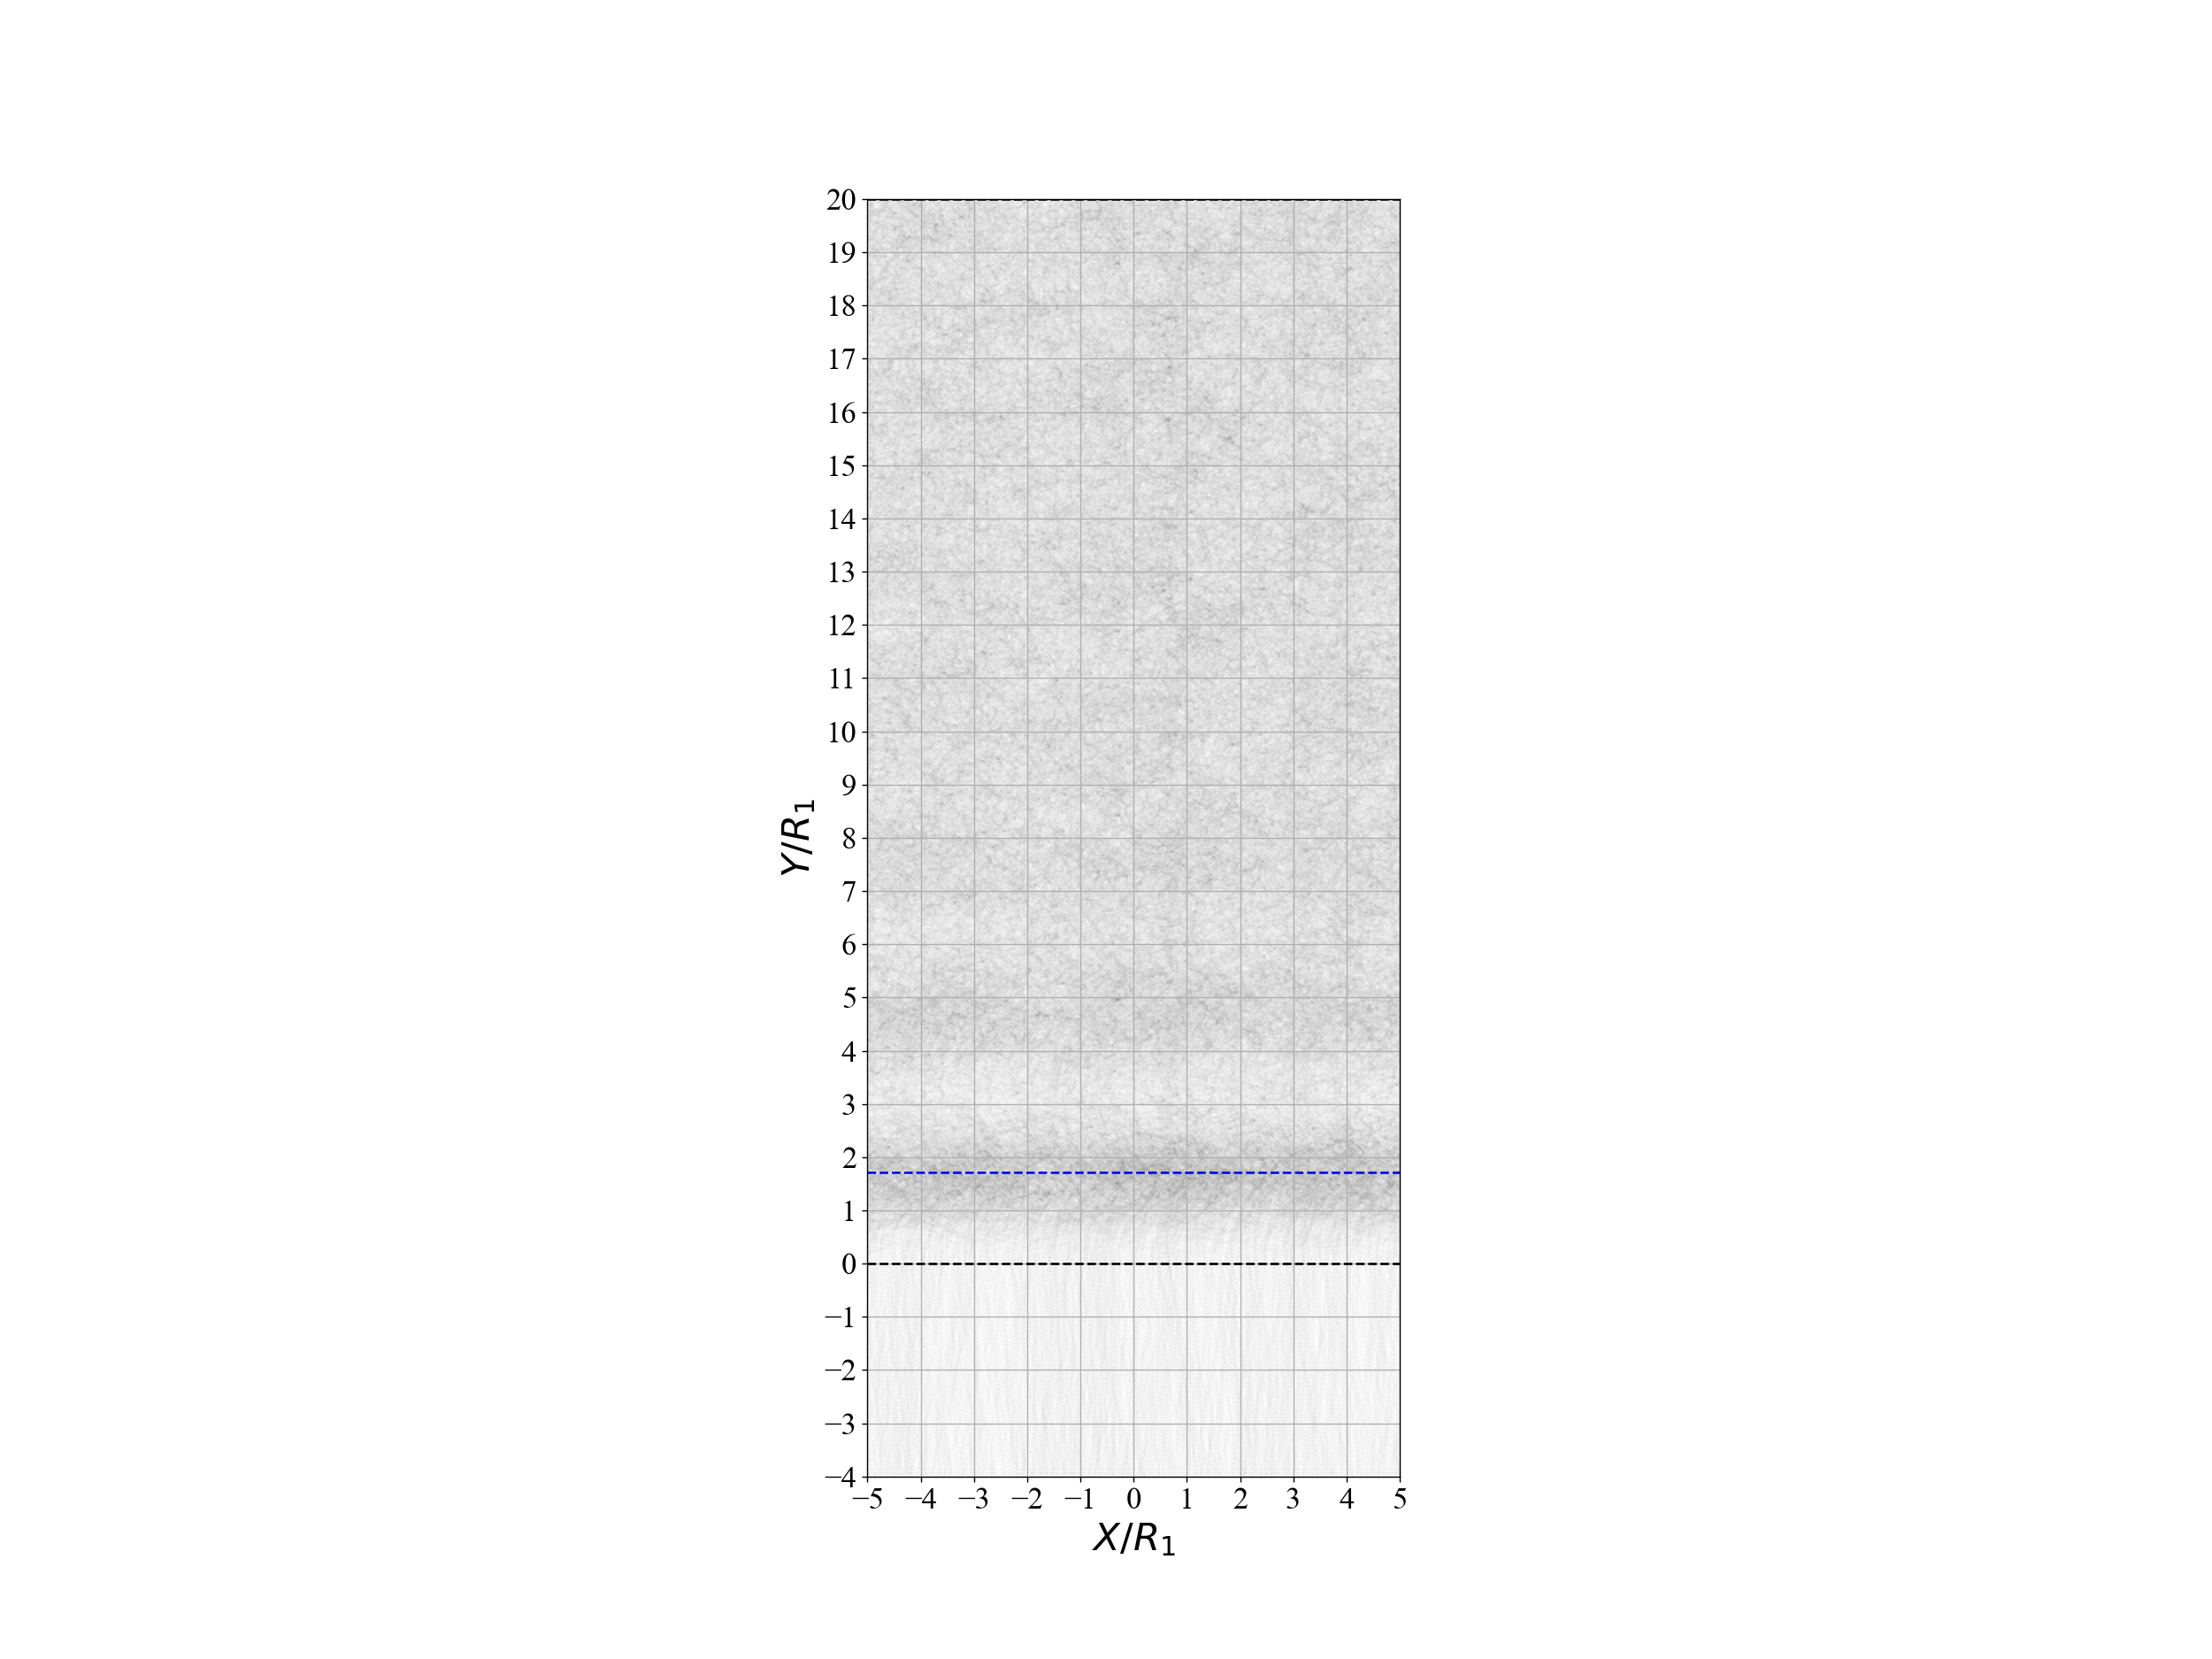

In [28]:
ynlim = 1500
y0 = -4.0*R1 

nstep = 20

fig,ax = plt.subplots(1,1,figsize=(20, 15))

ax.scatter(rx[:ynlim,0:50000:nstep]/R1,ry[:ynlim,0:50000:nstep]/R1,s=0.00002, color='k')


for i in range(0,1):
    
    ax.axhline(y= (2*i+1)/2*y_p, color='blue', linestyle='--')
    
ax.axhline(y=0.0, color='k', linestyle='--')
ax.axhline(y=20., color='k', linestyle='--')

ax.set_ylim([-4,20]);  #[y0/R1,100.5]
ax.set_xlim([-5,5])

ax.set_xticks(np.arange(-5,5.1,1))

ax.set_yticks(np.arange(-4,20.1, 1))

ax.set_xlabel(r'$X/R_1$',size=25);ax.set_ylabel(r'$Y/R_1$',size= 25)
ax.tick_params(axis='both', which='major', labelsize = 20 )
ax.grid(axis='both')

ax.set_aspect(1)

plt.savefig('MonteCarlo07102015_3D.png',dpi=150, bbox_inches='tight',facecolor='w', edgecolor='w')
#plt.savefig('MonteCarlo07102015_3D_v2.png', bbox_inches='tight',facecolor='w', edgecolor='w')

#plt.savefig(path_in+'3D\\'+'plot_3D_50000_particles.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

#plt.savefig('MonteCarlo07102015_3D_v4.png', bbox_inches='tight',dpi=150, facecolor='w', edgecolor='w')

### Discretização

In [ ]:
rx.shape, ry.shape

In [ ]:
# Ajuste do tamanho dos vetores posição (rx e ry) para realizar a descritização dentro de uma faixa especifica.
rx_d = rx[:ynlim,:]; ry_d = ry[:ynlim,:]

rx_d.shape, ry_d.shape

In [ ]:
x_1 = -5.0; y_1 = -4  ; z0lower = -1.0
x_2 =  5.0; y_2 = 20  ; z0upper =  1.0

# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10
dz = (z0upper-z0lower)

# Definição das regiões pré-choque e pós-choque
i_up = round((0-y_1)/dy)     # Construção dos indices para os vetores
i_dw = round((y_2-y_1)/dy)

# Discretização 
x_i = round((x_2-x_1)/dx)
y_i = round((y_2-y_1)/dy)

rx = rx_d/R1; ry = ry_d/R1
    
#Cálculo das densidades numéricas    
cc   = np.zeros((x_i, y_i))
c_vx = np.zeros((x_i, y_i))
c_vy = np.zeros((x_i, y_i))
c_vz = np.zeros((x_i, y_i))

x_size = np.arange(len(rx))
y_size = np.arange(len(rx[0,:]))

x_ii = np.arange(x_1, x_2  , dx)
y_jj = np.arange(y_1, y_2  , dy)

for i in x_size:
    
    for j in y_size:
        
        for k in x_ii:
            
            if k <rx[i,j]< k + dx:
                
                for l in y_jj:
                    
                    if l < ry[i,j] < l+dy:
                        
                        cc[round((k-x_1)/dx),   round((l-y_1)/dy)]  += 1
                        c_vx[round((k-x_1)/dx), round((l-y_1)/dx)]  += vx[i,j]
                        c_vy[round((k-x_1)/dy), round((l-y_1)/dy)]  += vy[i,j]
                        c_vz[round((k-x_1)/dz), round((l-y_1)/dz)]  += vz[i,j]
                        
                        break
                break
                
cm_vx = c_vx/cc; cm_vy = c_vy/cc ; cm_vz = c_vz/cc # Valores médios
cc_n = cc/np.max(cc)  
    
#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2+cm_vz**2)

w_i = (n1*1e6*v1n)/((cc*cm_v)/(dx*R1*dy*R1*dz*R1))  
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1*dz*R1)
    
aa = np.mean(Z_d[:][0:i_up])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vy.T 

#Fluxo em Z   
F_Z = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vz.T 

### Salvamento (primeira iteração)

In [ ]:
#path_in+'boris2D\\Extensao\\ ; path_in+'boris2D\\'+'cc_01.txt'
#path_in+'boris2D\\Extensao_100

#np.savetxt(path_in+'3D\\'+'cc_skp1_20.txt', cc) 
#np.savetxt(path_in+'3D\\'+'w_i_skp1_20.txt', w_i) 
#np.savetxt(path_in+'3D\\'+'cvx_skp1_20.txt', cm_vx)
#np.savetxt(path_in+'3D\\'+'cvy_skp1_20.txt', cm_vy)
#np.savetxt(path_in+'3D\\'+'cvz_skp1_20.txt', cm_vz)

### Carregamento 

In [21]:
cc    = np.loadtxt(path_in+'3D\\'+'cc_skp1_20.txt')
w_i   = np.loadtxt(path_in+'3D\\'+'w_i_skp1_20.txt') 
cm_vx = np.loadtxt(path_in+'3D\\'+'cvx_skp1_20.txt')
cm_vy = np.loadtxt(path_in+'3D\\'+'cvy_skp1_20.txt')
cm_vz = np.loadtxt(path_in+'3D\\'+'cvz_skp1_20.txt')

In [22]:
x_1 = -5.0; y_1 = -4  ; z0lower = -1.0
x_2 =  5.0; y_2 = 20.0; z0upper =  1.0

# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10
dz = (z0upper-z0lower)

# Definição das regiões pré-choque e pós-choque
i_up = round((0-y_1)/dy)     # Construção dos indices para os vetores
i_dw = round((y_2-y_1)/dy)

cc_n = cc/np.max(cc) 
    
#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2+cm_vz**2)

w_i = (n1*1e6*v1n)/((cc*cm_v)/(dx*R1*dy*R1*dz*R1))  
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1*dz*R1)
    
aa = np.mean(Z_d[:][0:i_up])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vy.T 

#Fluxo em Z   
F_Z = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vz.T 

### Contas  

In [23]:
#Média dos fluxos (x,y,z) nas regiões pré e pós choque.
f11 = np.mean(F_X[:][0:i_up])/1e11
f12 = np.mean(F_X[:][i_up:i_dw])/1e11 

f21 = np.mean(F_Y[:][0:i_up])/1e11
f22 = np.mean(F_Y[:][i_up:i_dw])/1e11 

f31 = np.mean(F_Z[:][0:i_up])/1e11
f32 = np.mean(F_Z[:][i_up:i_dw])/1e11 

F_1 = np.sqrt(f11**2+f21**2+f31**2)  
F_2 = np.sqrt(f12**2+f22**2+f32**2)

n_1 = (aa*1e6)
n_2 = (bb*1e6)

#Estimativa da velocidade média a partir do fluxo médio e da densidade.
v_1 = (F_1*1e11)/n_1 
v_2 = (F_2*1e11)/n_2

# Vetores dos fluxos simulados (média nos bins)
Fx = pd.DataFrame(F_X,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
Fy = pd.DataFrame(F_Y,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
Fz = pd.DataFrame(F_Z,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))

Fx = Fx.T/1e11
Fy = Fy.T/1e11
Fz = Fz.T/1e11

Fx

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,0.939377,0.358082,0.571990,0.414758,0.193336,0.101338,0.265911,-0.174426,-0.308016,-0.508137,...,-1.555324,-2.677475,-1.037618,3.713188,7.428042,-0.452966,-3.439255,6.837447,-0.286414,7.476954
-4.85,-0.128079,0.100294,0.282775,0.156546,0.366272,0.011404,-0.518064,-0.211210,-0.054562,-0.110801,...,-1.661897,-5.567878,0.858454,0.927197,5.521337,3.777662,-2.695797,2.537810,1.468117,6.928048
-4.75,0.081055,-0.379860,-0.400236,-0.550732,-0.406212,-0.439972,0.497282,0.677499,0.670622,0.200067,...,0.814385,-2.187685,-0.400207,2.398595,2.292035,1.240919,3.601115,6.337643,3.241557,3.353199
-4.65,0.595836,0.365799,0.016611,-0.091010,-0.026639,0.195080,-0.361445,-0.230448,-0.434364,-0.864361,...,-1.373901,-2.848056,-3.978646,3.791825,2.396841,3.517387,4.190482,0.537648,1.135003,4.181694
-4.55,0.323520,0.440168,0.496040,-0.176852,-0.649948,-0.345252,-0.829476,-0.551725,-0.290619,-0.562022,...,-2.389865,1.669068,-1.056898,3.963801,1.801156,3.932675,1.513616,1.070438,3.545574,0.446588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,-0.882436,-1.007006,-0.397092,-0.793628,-0.037077,-0.347209,-0.340595,-0.533514,-0.212773,-0.626928,...,0.055441,2.123493,4.456801,-1.478898,1.615183,-2.050468,3.922909,0.474431,1.479549,4.695031
4.65,0.107503,0.135999,0.445902,-0.420249,-0.420839,-0.668736,-1.073271,-0.419083,-1.237659,-0.304308,...,2.664677,3.463012,-0.113823,1.346011,-1.467662,2.096721,2.062669,2.005633,5.930385,10.455450
4.75,-0.470713,-0.848509,-0.187153,0.236914,0.161907,0.279882,0.107687,-0.757982,0.028674,-0.327359,...,1.787541,0.587904,-0.140385,-1.304906,4.224189,1.985844,-0.072286,8.070456,4.473092,4.941621
4.85,0.671484,0.476392,0.267446,-0.097456,-0.176230,0.560393,-0.736493,0.461735,0.186363,-0.128443,...,-6.560495,5.323670,2.039650,-0.400320,3.299051,2.266913,1.953827,3.462421,5.729055,3.355655


In [24]:
Fy

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,82.269854,81.396160,67.581594,64.557905,44.867854,81.892524,45.684453,65.057032,66.963336,58.524697,...,83.084649,83.056060,83.092727,83.016204,82.766552,83.097971,83.028004,82.817433,83.098712,82.762148
-4.85,61.869552,58.238944,51.395356,22.259457,37.444848,24.260953,49.797088,25.230065,27.778298,33.999369,...,83.082586,82.912464,83.094771,83.094032,82.915576,83.013295,83.055467,83.060445,83.086236,82.809903
-4.75,71.706378,61.347084,82.386738,80.612937,40.293177,83.031679,42.731534,82.904591,48.807268,50.139400,...,83.095215,83.070404,83.098242,83.064581,83.067590,83.089940,83.021141,82.857180,83.035957,83.031524
-4.65,82.396194,80.042266,54.371771,60.215011,42.655819,44.248120,44.505233,63.141855,33.253488,71.894417,...,83.087847,83.050385,83.003905,83.012650,83.064632,83.024731,82.993480,83.097466,83.091454,82.993924
-4.55,83.095953,82.947303,73.372454,42.606897,54.985013,43.940274,66.765656,51.915692,43.140496,52.928073,...,83.064833,83.082442,83.092484,83.004616,83.079683,83.006096,83.085419,83.092311,83.023532,83.098005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,83.094520,83.093104,83.098257,83.095416,83.099197,83.098480,83.098507,83.097493,83.098933,83.096840,...,83.099187,83.072069,82.979605,83.086044,83.083507,83.073904,83.006558,83.097851,83.086033,82.966467
4.65,83.099136,83.099094,83.098009,83.098143,83.098140,83.096514,83.092274,83.098149,83.089988,83.098648,...,83.056471,83.027017,83.099127,83.088304,83.086244,83.072749,83.073602,83.074998,82.887324,82.438835
4.75,83.097872,83.094873,83.098995,83.098868,83.099048,83.098734,83.099136,83.095748,83.099200,83.098561,...,83.079977,83.097126,83.099087,83.088959,82.991772,83.075474,83.099174,82.706382,82.978728,82.952145
4.85,83.096492,83.097840,83.098775,83.099148,83.099018,83.097316,83.095942,83.097923,83.098996,83.099106,...,82.839832,82.928502,83.074170,83.098241,83.033693,83.068279,83.076233,83.027041,82.901483,83.031425


In [25]:
Fz   # Não entendi porque zerou alguns termos da matriz no fluxo em Z

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,-11.673329,-16.733643,-48.351618,-52.321915,-69.945095,-14.109649,-69.414249,-51.701354,-49.206653,-58.992199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4.85,-55.476301,-59.276415,-65.298662,-80.062288,-74.183739,-79.478827,-66.524128,-79.176241,-78.318843,-75.825514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4.75,41.996032,56.052376,-10.850949,-20.167522,-72.675806,-3.320341,-71.268834,5.643373,-67.252352,-66.268232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4.65,10.769872,22.328898,62.842566,57.267985,71.315905,70.338779,70.175719,54.023430,76.154414,41.664417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4.55,0.660133,5.002903,39.009165,71.344929,62.303321,70.530922,49.468546,64.884008,71.023173,64.060761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.65,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.75,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.85,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


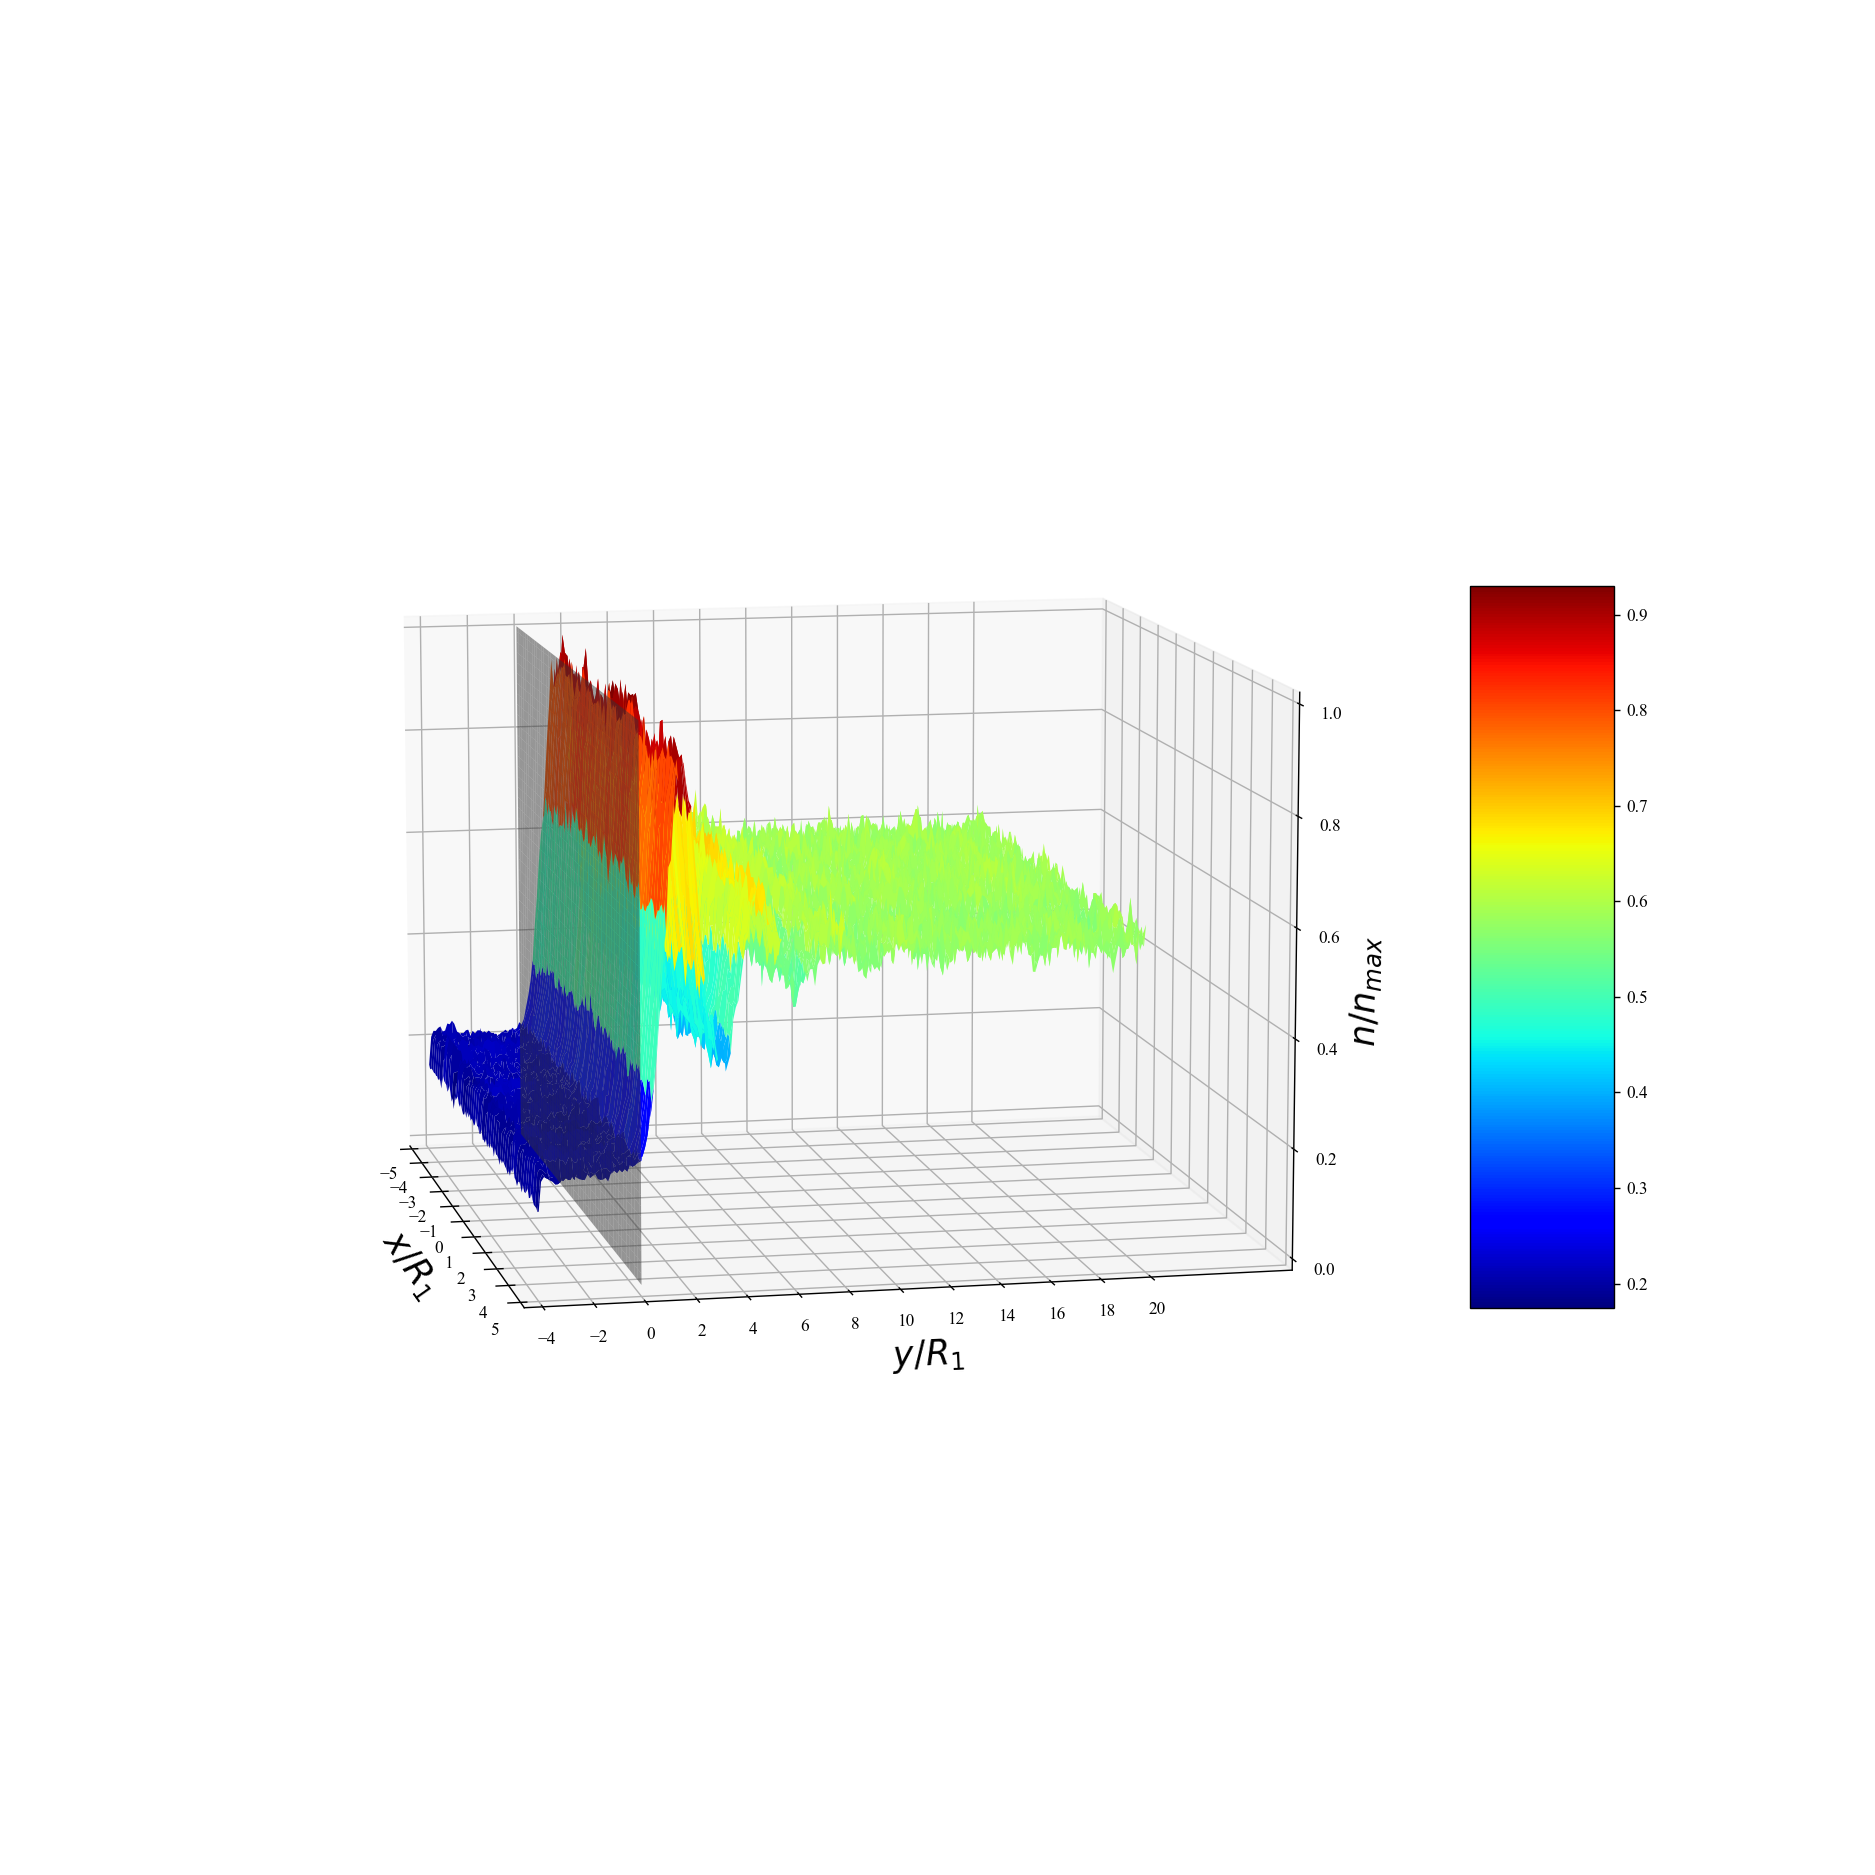

In [26]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(15,15))

# Make data.

X = np.arange(-5+dx/2,5,dx)
Y = np.arange(-4+dy/2,20.,dy)

X, Y = np.meshgrid(X, Y)

Z = cc_n.T   #Usando transposta


# Plot the surface.
surf = ax.plot_surface(X, Y, Z , cmap='jet')

z_p, x_p = np.meshgrid(np.linspace(0,1,100),np.linspace(-5,5, 100))

y_p = x_p*0

ax.plot_surface(x_p, y_p, z_p, color= "gray", alpha=0.5)  # the vertical plane

ax.set_xlabel(r'$x/R_1$',size=20)
ax.set_ylabel(r'$y/R_1$',size=20, labelpad=10)
ax.set_zlabel(r'$n/n_{max}$',size=20)

ax.set_xlim([-4.9,5.1])
ax.set_ylim([-4.1,25.1])

ax.set_xticks(np.arange(-5,5.1,1))
ax.set_yticks(np.arange(-4.,20.1,2))


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] )

ax.view_init(10, -12)

#plt.savefig(path_in+'boris2D\\Extensao\\Densidade númerica_50000_particles_01.png',
#dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

## Estimativa dos erros

In [27]:
cc_td =  pd.DataFrame(cc,  index =np.arange(x_1+dx/2,x_2,dx) , columns = np.arange(y_1+dy/2,y_2,dy))
cc_td

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,535.0,736.0,778.0,777.0,798.0,808.0,771.0,777.0,827.0,821.0,...,2045.0,2087.0,2075.0,2128.0,2142.0,2190.0,2157.0,2150.0,2174.0,2143.0
-4.85,510.0,730.0,793.0,779.0,773.0,798.0,772.0,826.0,754.0,771.0,...,2165.0,2001.0,2059.0,2061.0,2135.0,2212.0,2066.0,2137.0,1974.0,2076.0
-4.75,526.0,727.0,765.0,714.0,725.0,748.0,729.0,748.0,721.0,729.0,...,2165.0,2049.0,2143.0,2078.0,2097.0,2177.0,2175.0,2182.0,2128.0,2083.0
-4.65,529.0,735.0,753.0,759.0,752.0,750.0,758.0,757.0,751.0,762.0,...,2079.0,2219.0,2122.0,2197.0,2008.0,2084.0,1999.0,2053.0,2154.0,2162.0
-4.55,525.0,752.0,787.0,772.0,777.0,779.0,777.0,769.0,783.0,804.0,...,2107.0,2173.0,2044.0,2008.0,2173.0,2145.0,2016.0,2304.0,2079.0,2050.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,508.0,724.0,739.0,767.0,757.0,766.0,761.0,782.0,809.0,796.0,...,2179.0,2165.0,2142.0,2024.0,2177.0,2028.0,2043.0,2122.0,2131.0,2159.0
4.65,508.0,728.0,751.0,741.0,722.0,724.0,696.0,690.0,667.0,678.0,...,2048.0,2117.0,2161.0,2129.0,2150.0,2071.0,2132.0,2023.0,2145.0,2024.0
4.75,508.0,699.0,707.0,694.0,706.0,709.0,739.0,738.0,752.0,698.0,...,2134.0,2167.0,2146.0,2144.0,2138.0,2166.0,2019.0,2195.0,1966.0,2074.0
4.85,492.0,701.0,739.0,714.0,706.0,695.0,686.0,667.0,668.0,681.0,...,2206.0,2169.0,2140.0,2188.0,2080.0,2081.0,1951.0,2134.0,2196.0,2065.0


### Contagem de partículas na região pré-choque

In [28]:
cc_up = pd.DataFrame(cc[:,0:i_up], index = np.arange(x_1+dx/2,x_2,dx) , columns = np.arange(y_1+dy/2,0,dy) ) 
cc_up

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,535.0,736.0,778.0,777.0,798.0,808.0,771.0,777.0,827.0,821.0,...,732.0,708.0,751.0,766.0,749.0,754.0,778.0,763.0,775.0,816.0
-4.85,510.0,730.0,793.0,779.0,773.0,798.0,772.0,826.0,754.0,771.0,...,742.0,724.0,729.0,706.0,737.0,740.0,750.0,730.0,762.0,742.0
-4.75,526.0,727.0,765.0,714.0,725.0,748.0,729.0,748.0,721.0,729.0,...,759.0,770.0,763.0,763.0,784.0,779.0,785.0,767.0,781.0,787.0
-4.65,529.0,735.0,753.0,759.0,752.0,750.0,758.0,757.0,751.0,762.0,...,778.0,757.0,772.0,742.0,732.0,729.0,742.0,717.0,745.0,725.0
-4.55,525.0,752.0,787.0,772.0,777.0,779.0,777.0,769.0,783.0,804.0,...,712.0,756.0,701.0,723.0,766.0,778.0,782.0,750.0,806.0,799.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,508.0,724.0,739.0,767.0,757.0,766.0,761.0,782.0,809.0,796.0,...,724.0,713.0,751.0,777.0,755.0,743.0,743.0,750.0,796.0,816.0
4.65,508.0,728.0,751.0,741.0,722.0,724.0,696.0,690.0,667.0,678.0,...,790.0,742.0,756.0,757.0,765.0,770.0,804.0,805.0,815.0,784.0
4.75,508.0,699.0,707.0,694.0,706.0,709.0,739.0,738.0,752.0,698.0,...,777.0,757.0,774.0,789.0,789.0,812.0,800.0,755.0,766.0,783.0
4.85,492.0,701.0,739.0,714.0,706.0,695.0,686.0,667.0,668.0,681.0,...,739.0,724.0,745.0,728.0,748.0,730.0,773.0,760.0,770.0,783.0


### Contagem na região pós-choque

In [29]:
cc_dw = pd.DataFrame(cc[:,i_up:], index = np.arange(x_1+dx/2,x_2,dx) , columns = np.arange(0+dy/2,y_2,dy) ) 
cc_dw

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,800.0,838.0,926.0,1008.0,1111.0,1258.0,1505.0,1706.0,1964.0,2164.0,...,2045.0,2087.0,2075.0,2128.0,2142.0,2190.0,2157.0,2150.0,2174.0,2143.0
-4.85,791.0,866.0,849.0,943.0,1133.0,1233.0,1438.0,1667.0,1884.0,2148.0,...,2165.0,2001.0,2059.0,2061.0,2135.0,2212.0,2066.0,2137.0,1974.0,2076.0
-4.75,828.0,888.0,929.0,1008.0,1154.0,1247.0,1548.0,1700.0,1912.0,2256.0,...,2165.0,2049.0,2143.0,2078.0,2097.0,2177.0,2175.0,2182.0,2128.0,2083.0
-4.65,739.0,752.0,866.0,992.0,1070.0,1155.0,1398.0,1637.0,1937.0,2171.0,...,2079.0,2219.0,2122.0,2197.0,2008.0,2084.0,1999.0,2053.0,2154.0,2162.0
-4.55,814.0,842.0,907.0,945.0,1115.0,1199.0,1407.0,1583.0,1828.0,2140.0,...,2107.0,2173.0,2044.0,2008.0,2173.0,2145.0,2016.0,2304.0,2079.0,2050.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,861.0,889.0,962.0,1034.0,1138.0,1280.0,1451.0,1711.0,1878.0,2142.0,...,2179.0,2165.0,2142.0,2024.0,2177.0,2028.0,2043.0,2122.0,2131.0,2159.0
4.65,823.0,825.0,871.0,936.0,1150.0,1296.0,1462.0,1643.0,1855.0,2198.0,...,2048.0,2117.0,2161.0,2129.0,2150.0,2071.0,2132.0,2023.0,2145.0,2024.0
4.75,795.0,866.0,906.0,1003.0,1107.0,1166.0,1453.0,1693.0,1845.0,2163.0,...,2134.0,2167.0,2146.0,2144.0,2138.0,2166.0,2019.0,2195.0,1966.0,2074.0
4.85,804.0,827.0,885.0,965.0,1096.0,1235.0,1413.0,1586.0,1907.0,2122.0,...,2206.0,2169.0,2140.0,2188.0,2080.0,2081.0,1951.0,2134.0,2196.0,2065.0


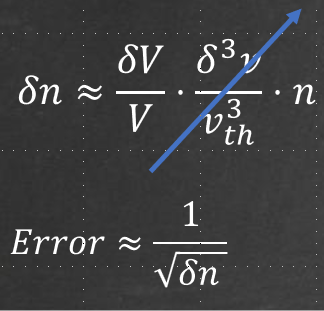

In [30]:
DLLn1 = ( (dx*dy)/(i_up) )*np.sum(cc[:,0:i_up])
DLLn2 = ( (dx*dy)/(i_dw-i_up) )*np.sum(cc[:,i_up:])

dln1 = 1/np.sqrt(DLLn1)
dln2 = 1/np.sqrt(DLLn2)

dln1, dln2    # Erro percentual nas regiões pré e pós choque.

(0.03640980679261336, 0.021724227090635605)

In [31]:
#Usando transposta
Z = w_i.T*cc.T/(dx*R1*dy*R1*dz*R1)

n_massa = pd.DataFrame(Z,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
n_mass  = n_massa.T

n_mass = n_mass/1e6

In [32]:
n_mass

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,21.075802,21.511583,17.456225,16.795178,11.715032,21.296808,11.935038,16.992683,17.596713,15.478111,...,56.523650,60.590350,60.912666,59.671607,58.346411,62.595756,59.293642,57.595052,55.392815,59.760642
-4.85,16.203604,15.723800,13.635282,5.887071,9.891622,6.391115,13.172136,6.706871,7.337661,8.916869,...,61.184168,58.232545,61.843258,60.596088,62.138106,57.929813,63.310234,63.091760,60.876610,57.991286
-4.75,18.891046,16.486308,21.750509,21.448241,10.748680,22.022375,11.360130,21.821746,12.827285,13.095127,...,62.110830,58.712837,59.747196,60.908203,58.171411,61.386062,60.582050,64.161875,62.004921,62.011968
-4.65,21.451893,21.401825,14.299673,15.708356,11.147294,11.598914,11.656595,16.597286,8.793952,18.937097,...,65.307777,69.025008,64.420127,64.624070,64.492242,65.990107,63.601744,62.545577,63.438266,60.897418
-4.55,21.229114,21.960736,19.013364,11.121913,14.433953,11.486749,17.506948,13.587637,11.303335,13.926272,...,59.481586,62.775315,66.426648,63.770969,65.198338,66.627588,61.689196,65.432456,58.684065,61.094085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,21.552881,22.288707,21.855280,21.944843,21.955029,21.983720,22.122282,22.148713,22.268712,22.231609,...,58.852467,63.746723,63.201026,58.336266,58.657583,56.561387,57.476481,56.215293,58.447269,57.697710
4.65,21.690822,22.272429,21.973896,21.840346,21.874857,21.845278,21.729202,21.655575,21.709793,21.620615,...,60.651041,61.080599,61.526610,55.479406,64.093331,59.662308,58.502851,60.951588,64.661288,59.765546
4.75,21.572194,22.130288,21.661767,21.773831,21.717883,21.794816,21.791448,21.742308,21.781543,21.781144,...,61.330120,58.171591,61.174243,61.757939,61.574558,64.321133,59.562188,62.979254,59.285958,63.205894
4.85,21.645058,22.325519,21.947290,21.913854,22.082789,21.990249,21.872148,21.906159,21.756544,21.865577,...,60.003417,59.257327,58.987122,63.473463,58.492976,60.029554,57.928123,61.315122,58.026913,56.916383


### Região pré-choque

In [33]:
n_mass[n_mass.columns[0:i_up]]

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,21.075802,21.511583,17.456225,16.795178,11.715032,21.296808,11.935038,16.992683,17.596713,15.478111,...,21.813796,21.824680,21.882784,21.835967,21.831525,22.369230,22.431820,22.355041,22.322479,22.320732
-4.85,16.203604,15.723800,13.635282,5.887071,9.891622,6.391115,13.172136,6.706871,7.337661,8.916869,...,21.726619,21.508848,21.542883,21.705680,21.922948,22.007445,22.142000,22.111555,22.052510,21.965970
-4.75,18.891046,16.486308,21.750509,21.448241,10.748680,22.022375,11.360130,21.821746,12.827285,13.095127,...,21.663439,21.677477,21.689491,21.855401,22.013768,22.226819,22.402680,22.685142,22.405467,22.361207
-4.65,21.451893,21.401825,14.299673,15.708356,11.147294,11.598914,11.656595,16.597286,8.793952,18.937097,...,21.746054,21.903025,21.699165,21.669533,21.686240,21.972233,22.093479,22.158456,22.753326,22.800710
-4.55,21.229114,21.960736,19.013364,11.121913,14.433953,11.486749,17.506948,13.587637,11.303335,13.926272,...,21.446298,21.702372,21.709520,21.799004,22.177324,22.117065,22.390205,22.010862,22.542264,22.637877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,21.552881,22.288707,21.855280,21.944843,21.955029,21.983720,22.122282,22.148713,22.268712,22.231609,...,22.209301,22.017818,22.101132,22.176103,22.313547,22.330141,22.355637,22.934080,22.792870,23.148479
4.65,21.690822,22.272429,21.973896,21.840346,21.874857,21.845278,21.729202,21.655575,21.709793,21.620615,...,21.675771,21.675719,21.833356,22.035335,22.404097,22.511120,22.515128,22.747087,22.975020,23.017768
4.75,21.572194,22.130288,21.661767,21.773831,21.717883,21.794816,21.791448,21.742308,21.781543,21.781144,...,21.711931,21.764906,21.678424,22.109222,21.891690,22.208407,22.277176,22.271783,22.636592,22.691961
4.85,21.645058,22.325519,21.947290,21.913854,22.082789,21.990249,21.872148,21.906159,21.756544,21.865577,...,21.882658,21.849104,21.848047,22.144291,22.220427,22.127920,22.232665,22.367119,22.372068,22.804244


### Região pós-choque 

In [34]:
n_mass[n_mass.columns[i_up:]]

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,23.024828,24.196109,26.596492,28.905011,31.081658,34.219568,41.170030,43.507395,50.678813,52.670966,...,56.523650,60.590350,60.912666,59.671607,58.346411,62.595756,59.293642,57.595052,55.392815,59.760642
-4.85,23.129096,24.362431,25.902318,28.568758,32.464333,35.598996,40.940395,46.805826,52.681086,63.186344,...,61.184168,58.232545,61.843258,60.596088,62.138106,57.929813,63.310234,63.091760,60.876610,57.991286
-4.75,23.308179,24.543191,26.226951,28.068547,31.532311,33.857096,40.099760,46.482164,51.573295,60.988293,...,62.110830,58.712837,59.747196,60.908203,58.171411,61.386062,60.582050,64.161875,62.004921,62.011968
-4.65,22.790673,24.522771,26.969716,28.892891,32.339692,35.687804,40.602176,45.473125,50.919865,57.403923,...,65.307777,69.025008,64.420127,64.624070,64.492242,65.990107,63.601744,62.545577,63.438266,60.897418
-4.55,23.143747,24.224451,25.786843,28.621965,31.581334,34.502206,41.214585,45.084997,51.246671,59.701556,...,59.481586,62.775315,66.426648,63.770969,65.198338,66.627588,61.689196,65.432456,58.684065,61.094085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,23.710167,24.439373,25.366772,28.759730,31.904329,35.579250,39.842378,48.462151,52.826898,62.237297,...,58.852467,63.746723,63.201026,58.336266,58.657583,56.561387,57.476481,56.215293,58.447269,57.697710
4.65,23.689424,24.595004,25.887852,27.913147,32.541666,35.948207,42.025828,47.052390,49.774553,57.626126,...,60.651041,61.080599,61.526610,55.479406,64.093331,59.662308,58.502851,60.951588,64.661288,59.765546
4.75,23.789948,24.644160,26.368854,27.136227,30.884021,33.694751,42.055070,45.280173,48.707088,56.107657,...,61.330120,58.171591,61.174243,61.757939,61.574558,64.321133,59.562188,62.979254,59.285958,63.205894
4.85,23.156802,24.842912,26.700828,29.136415,31.304834,34.299948,37.433612,45.139706,50.530313,56.725966,...,60.003417,59.257327,58.987122,63.473463,58.492976,60.029554,57.928123,61.315122,58.026913,56.916383


In [35]:
n_mass.describe()

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,21.523308,22.107957,21.593522,21.432141,21.295556,21.465339,21.377270,21.461429,21.321852,21.363590,...,60.475221,60.838652,60.725310,60.461981,61.110673,61.454922,61.238196,61.558892,61.138619,61.542071
std,0.632445,0.891448,1.223961,2.068607,2.308243,2.108962,1.996652,1.895740,2.393260,1.991611,...,3.436133,3.026465,3.241725,2.652550,2.905451,3.041854,2.966170,2.812210,3.096150,2.733244
min,16.203604,15.723800,13.635282,5.887071,9.891622,6.391115,11.360130,6.706871,7.337661,8.916869,...,52.673275,54.282113,53.414915,53.525208,54.461146,54.656197,51.678411,52.975931,54.632071,55.956180
25%,21.448699,22.127192,21.677526,21.689111,21.698534,21.709362,21.697873,21.693533,21.672440,21.683907,...,58.040030,58.566946,58.359067,58.911147,59.010046,59.255121,59.196186,59.885571,58.691822,59.596964
50%,21.594147,22.238825,21.832759,21.826550,21.837650,21.837809,21.826147,21.799538,21.811990,21.787595,...,60.591857,60.719893,60.439121,60.720484,61.053668,61.412229,61.431378,61.794722,61.253560,61.111569
75%,21.758579,22.376652,21.917503,21.945830,21.944838,21.935013,21.930221,21.954315,21.942421,21.936840,...,62.838077,63.416531,62.342410,62.290627,62.913619,62.948451,63.126440,63.280703,63.455313,63.450245
max,22.072116,22.673667,22.296091,22.358899,22.419926,22.228014,22.271638,22.289746,22.390406,22.317621,...,68.637617,69.025008,69.241690,65.537951,72.243871,71.242447,67.617817,67.315476,67.605673,68.723853


In [36]:
#Número de partículas na região pré e pós choque.

np.sum(cc[:,0:i_up]), np.sum(cc[:,i_up:])

(3017333.0, 42378085.0)

In [37]:
d_up = np.mean(np.mean(n_mass[n_mass.columns[0:i_up]]))
d_dw = np.mean(np.mean(n_mass[n_mass.columns[i_up:]]))

d_up, d_dw

(21.779511757547265, 60.49465661843763)

In [38]:
nsig_up = n_mass[n_mass.columns[0:i_up]]*dln1   # dln1 é o erro percentual estimado para cada bin na região pré-choque
nsig_dw = n_mass[n_mass.columns[i_up:]] *dln2   # dln2 é o erro percentual estimado para cada bin na região pós-choque

In [39]:
nsig_up

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,0.767366,0.783233,0.635578,0.611509,0.426542,0.775413,0.434552,0.618700,0.640693,0.563555,...,0.794236,0.794632,0.796748,0.795043,0.794882,0.814459,0.816738,0.813943,0.812757,0.812694
-4.85,0.589970,0.572501,0.496458,0.214347,0.360152,0.232699,0.479595,0.244196,0.267163,0.324661,...,0.791062,0.783133,0.784372,0.790300,0.798210,0.801287,0.806186,0.805077,0.802928,0.799777
-4.75,0.687819,0.600263,0.791932,0.780926,0.391357,0.801830,0.413620,0.794526,0.467039,0.476791,...,0.788762,0.789273,0.789710,0.795751,0.801517,0.809274,0.815677,0.825962,0.815779,0.814167
-4.65,0.781059,0.779236,0.520648,0.571938,0.405871,0.422314,0.424414,0.604304,0.320186,0.689496,...,0.791770,0.797485,0.790062,0.788983,0.789592,0.800005,0.804419,0.806785,0.828444,0.830169
-4.55,0.772948,0.799586,0.692273,0.404947,0.525537,0.418230,0.637425,0.494723,0.411552,0.507053,...,0.780856,0.790179,0.790439,0.793698,0.807472,0.805278,0.815223,0.801411,0.820759,0.824241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.784736,0.811528,0.795747,0.799007,0.799378,0.800423,0.805468,0.806430,0.810799,0.809449,...,0.808636,0.801664,0.804698,0.807428,0.812432,0.813036,0.813964,0.835025,0.829884,0.842832
4.65,0.789759,0.810935,0.800065,0.795203,0.796459,0.795382,0.791156,0.788475,0.790449,0.787202,...,0.789211,0.789209,0.794948,0.802302,0.815729,0.819626,0.819771,0.828217,0.836516,0.838072
4.75,0.785439,0.805760,0.788701,0.792781,0.790744,0.793545,0.793422,0.791633,0.793062,0.793047,...,0.790527,0.792456,0.789307,0.804993,0.797072,0.808604,0.811108,0.810911,0.824194,0.826210
4.85,0.788092,0.812868,0.799097,0.797879,0.804030,0.800661,0.796361,0.797599,0.792152,0.796121,...,0.796743,0.795522,0.795483,0.806269,0.809041,0.805673,0.809487,0.814382,0.814563,0.830298


In [40]:
nsig_dw

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,0.500197,0.525642,0.577788,0.627939,0.675225,0.743394,0.894387,0.945165,1.100958,1.144236,...,1.227933,1.316279,1.323281,1.296320,1.267531,1.359844,1.288109,1.251208,1.203366,1.298254
-4.85,0.502462,0.529255,0.562708,0.620634,0.705263,0.773361,0.889398,1.016820,1.144456,1.372674,...,1.329179,1.265057,1.343497,1.316403,1.349902,1.258480,1.375366,1.370620,1.322497,1.259816
-4.75,0.506352,0.533182,0.569760,0.609767,0.685015,0.735519,0.871136,1.009789,1.120390,1.324924,...,1.349310,1.275491,1.297962,1.323184,1.263729,1.333565,1.316098,1.393867,1.347009,1.347162
-4.65,0.495110,0.532738,0.585896,0.627676,0.702555,0.775290,0.882051,0.987868,1.106195,1.247056,...,1.418761,1.499515,1.399477,1.403908,1.401044,1.433584,1.381699,1.358754,1.378147,1.322949
-4.55,0.502780,0.526257,0.560199,0.621790,0.686080,0.749534,0.895355,0.979437,1.113294,1.296970,...,1.292191,1.363745,1.443068,1.385375,1.416384,1.447433,1.340150,1.421470,1.274866,1.327222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.515085,0.530926,0.551074,0.624783,0.693097,0.772932,0.865545,1.052803,1.147624,1.352057,...,1.278524,1.384848,1.372993,1.267310,1.274291,1.228752,1.248632,1.221234,1.269722,1.253438
4.65,0.514634,0.534307,0.562394,0.606392,0.706943,0.780947,0.912979,1.022177,1.081314,1.251883,...,1.317597,1.326929,1.336618,1.205247,1.392378,1.296118,1.270929,1.324126,1.404717,1.298360
4.75,0.516818,0.535375,0.572843,0.589514,0.670931,0.731992,0.913614,0.983677,1.058124,1.218895,...,1.332349,1.263733,1.328963,1.341643,1.337660,1.397327,1.293942,1.368176,1.287942,1.373099
4.85,0.503064,0.539693,0.580055,0.632966,0.680073,0.745140,0.813216,0.980625,1.097732,1.232328,...,1.303528,1.287320,1.281450,1.378912,1.270715,1.304096,1.258444,1.332024,1.260590,1.236464


In [41]:
np.sum(np.abs(nsig_up))

-3.95    78.365950
-3.85    80.494643
-3.75    78.621597
-3.65    78.034013
-3.55    77.536708
-3.45    78.154885
-3.35    77.834229
-3.25    78.140648
-3.15    77.632450
-3.05    77.784417
-2.95    77.911744
-2.85    77.849611
-2.75    78.821760
-2.65    79.410256
-2.55    79.379129
-2.45    79.423798
-2.35    79.342614
-2.25    79.328538
-2.15    79.310096
-2.05    79.301941
-1.95    79.266104
-1.85    79.278113
-1.75    79.219679
-1.65    79.203810
-1.55    79.181509
-1.45    79.234215
-1.35    79.221504
-1.25    79.276904
-1.15    79.252785
-1.05    79.475358
-0.95    79.472797
-0.85    79.487508
-0.75    79.598372
-0.65    79.775023
-0.55    80.129798
-0.45    80.635868
-0.35    81.219963
-0.25    81.428846
-0.15    82.067485
-0.05    82.846593
dtype: float64

In [42]:
np.sum(np.sum(np.abs(nsig_up))), i_up*cc.shape[0]   #Soma dos erros de cada bin na região pré-choque, número de bins na região pré-choque.

(3171.9512605189875, 4000)

In [43]:
err_up = np.sum(np.sum(np.abs(nsig_up)))/(i_up*cc.shape[0])   # Propagação do erro pré-choque para o calculo de uma média
err_dw = np.sum(np.sum(np.abs(nsig_dw)))/((i_dw-i_up)*cc.shape[0])  # Propagação do erro pós-choque

err_up, err_dw

(0.7929878151297469, 1.3141996581489614)

In [44]:
display(Markdown(rf'$n_1: {d_up:5.4}  \pm {err_up:1.3} $'))

$n_1: 21.78  \pm 0.793 $

In [45]:
display(Markdown(rf'$n_2: {d_dw:6.5}  \pm {err_dw:1.4} $'))

$n_2: 60.495  \pm 1.314 $

### Incerteza na densidade 

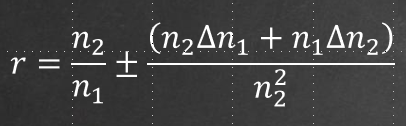

In [46]:
deln = (d_dw*err_up+d_up*err_dw)/(d_dw)**2
deln

0.020929631561673816

### Incerteza na velocidade

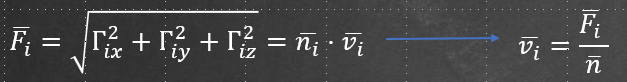

#### Cálculo dos fluxos médios

In [47]:
Fx_up = np.mean(np.mean(Fx[Fx.columns[0:i_up]]))
Fx_dw = np.mean(np.mean(Fx[Fx.columns[i_up:]]))

Fy_up = np.mean(np.mean(Fy[Fy.columns[0:i_up]]))
Fy_dw = np.mean(np.mean(Fy[Fy.columns[i_up:]]))

Fz_up = np.mean(np.mean(Fz[Fz.columns[0:i_up]]))
Fz_dw = np.mean(np.mean(Fz[Fz.columns[i_up:]]))

Fx_up, Fx_dw, Fy_up, Fy_dw, Fz_up, Fz_dw

(-1.5818869542519924,
 -0.440378538495185,
 82.62214982162517,
 82.34404864676735,
 -0.16576411606480543,
 0.0)

#### Estimativa das incertezas dos fluxos médios

In [48]:
nfx_up = Fx[Fx.columns[0:i_up]] * dln1  # dln1 é o erro percentual estimado para cada bin na região pré-choque
nfx_dw = Fx[Fx.columns[i_up:]]  * dln2  # dln2 é o erro percentual estimado para cada bin na região pós-choque

nfy_up = Fy[Fy.columns[0:i_up]] * dln1
nfy_dw = Fy[Fy.columns[i_up:]]  * dln2

nfz_up = Fz[Fz.columns[0:i_up]] * dln1
nfz_dw = Fz[Fz.columns[i_up:]]  * dln2

In [49]:
nfx_up 

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,0.034203,0.013038,0.020826,0.015101,0.007039,0.003690,0.009682,-0.006351,-0.011215,-0.018501,...,-0.095984,-0.068837,-0.088987,-0.129848,-0.101478,-0.177245,-0.228837,-0.201730,-0.249676,-0.228639
-4.85,-0.004663,0.003652,0.010296,0.005700,0.013336,0.000415,-0.018863,-0.007690,-0.001987,-0.004034,...,-0.101309,-0.092774,-0.137284,-0.140291,-0.173809,-0.204858,-0.230937,-0.198395,-0.222070,-0.188058
-4.75,0.002951,-0.013831,-0.014573,-0.020052,-0.014790,-0.016019,0.018106,0.024668,0.024417,0.007284,...,-0.075510,-0.094423,-0.119380,-0.132913,-0.169982,-0.186208,-0.209522,-0.214226,-0.191602,-0.192272
-4.65,0.021694,0.013319,0.000605,-0.003314,-0.000970,0.007103,-0.013160,-0.008391,-0.015815,-0.031471,...,-0.077655,-0.104015,-0.099149,-0.095075,-0.116594,-0.148067,-0.169319,-0.198869,-0.246229,-0.298941
-4.55,0.011779,0.016026,0.018061,-0.006439,-0.023664,-0.012571,-0.030201,-0.020088,-0.010581,-0.020463,...,-0.067023,-0.084942,-0.066014,-0.081251,-0.096123,-0.157814,-0.195403,-0.146169,-0.224071,-0.232825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,-0.032129,-0.036665,-0.014458,-0.028896,-0.001350,-0.012642,-0.012401,-0.019425,-0.007747,-0.022826,...,-0.039159,-0.054216,-0.112966,-0.122097,-0.184298,-0.188942,-0.176096,-0.244374,-0.207191,-0.216711
4.65,0.003914,0.004952,0.016235,-0.015301,-0.015323,-0.024349,-0.039078,-0.015259,-0.045063,-0.011080,...,-0.090709,-0.081745,-0.058689,-0.104597,-0.115688,-0.144517,-0.187867,-0.249761,-0.220504,-0.251287
4.75,-0.017139,-0.030894,-0.006814,0.008626,0.005895,0.010190,0.003921,-0.027598,0.001044,-0.011919,...,-0.044833,-0.020460,-0.058232,-0.118814,-0.117303,-0.180064,-0.197839,-0.150911,-0.177083,-0.215467
4.85,0.024449,0.017345,0.009738,-0.003548,-0.006416,0.020404,-0.026816,0.016812,0.006785,-0.004677,...,-0.076434,-0.080938,-0.079415,-0.140087,-0.090755,-0.107952,-0.187385,-0.169843,-0.160718,-0.215936


In [50]:
errfx_up = np.sum(np.sum(np.abs(nfx_up)))/(i_up*cc.shape[0])
errfx_dw = np.sum(np.sum(np.abs(nfx_dw)))/((i_dw-i_up)*cc.shape[0])  

errfy_up = np.sum(np.sum(np.abs(nfy_up)))/(i_up*cc.shape[0])
errfy_dw = np.sum(np.sum(np.abs(nfy_dw)))/((i_dw-i_up)*cc.shape[0])  

errfz_up = np.sum(np.sum(np.abs(nfz_up)))/(i_up*cc.shape[0])
errfz_dw = np.sum(np.sum(np.abs(nfz_dw)))/((i_dw-i_up)*cc.shape[0])  

errfx_up, errfx_dw, errfy_up, errfy_dw, errfz_up, errfz_dw

(0.0614070156819864,
 0.16369735845598585,
 3.008256511795726,
 1.7888608123647192,
 0.03459745272918624,
 0.0)

#### Região pré-choque

In [51]:
f_upx = Fx_up**2  
f_upy = Fy_up**2
f_upz = Fz_up**2

delf_upx =  np.abs(2*Fx_up*errfx_up)
delf_upy =  np.abs(2*Fy_up*errfy_up)
delf_upz =  np.abs(2*Fz_up*errfz_up)

#f_upx,f_upy, delf_upx, delf_upy

f_up    = (f_upx + f_upy + f_upz)
delf_up = (delf_upx + delf_upy + delf_upz)

F_up    = np.sqrt(f_up)
Delf_up = 0.5*(1/(np.sqrt(f_up)))*delf_up

round(F_up,3), round(Delf_up,3)      # Fluxo médio na região pré-choque mais a incerteza

(82.637, 3.009)

#### Região pós-choque

In [52]:
f_dwx = Fx_dw**2  
f_dwy = Fy_dw**2
f_dwz = Fz_dw**2

delf_dwx =  np.abs(2*Fx_dw*errfx_dw)
delf_dwy =  np.abs(2*Fy_dw*errfy_dw)
delf_dwz =  np.abs(2*Fz_dw*errfz_dw)

#f_upx,f_upy, delf_upx, delf_upy

f_dw    = (f_dwx + f_dwy + f_dwz)
delf_dw = (delf_dwx + delf_dwy + delf_dwz)

F_dw    = np.sqrt(f_dw)
Delf_dw = 0.5*(1/(np.sqrt(f_dw)))*delf_dw

round(F_dw,3), round(Delf_dw,3)      # Fluxo médio na região pré-choque mais a incerteza

(82.345, 1.79)

#### Incerteza nas velocidades

In [53]:
v_up    = F_up/d_up
v_dw    = F_dw/d_dw

Del_vup = (F_up*err_up+d_up*Delf_up)/d_up**2
Del_vdw = (F_dw*err_dw+d_dw*Delf_dw)/d_dw**2

round(v_up*1e5,3), round(Del_vup*1e5,3), round(v_dw*1e5,3), round(Del_vdw*1e5,3)

(379427.505, 27630.362, 136119.834, 5915.559)

#### Estimativa do r a partir das velocidades

In [54]:
r_v    = v_up/v_dw
del_rv = (v_up*Del_vdw + v_dw*Del_vup)/v_dw**2

round(r_v, 3), round(del_rv, 3)

(2.787, 0.324)

In [55]:
d_dw

60.49465661843763

<IPython.core.display.Javascript object>


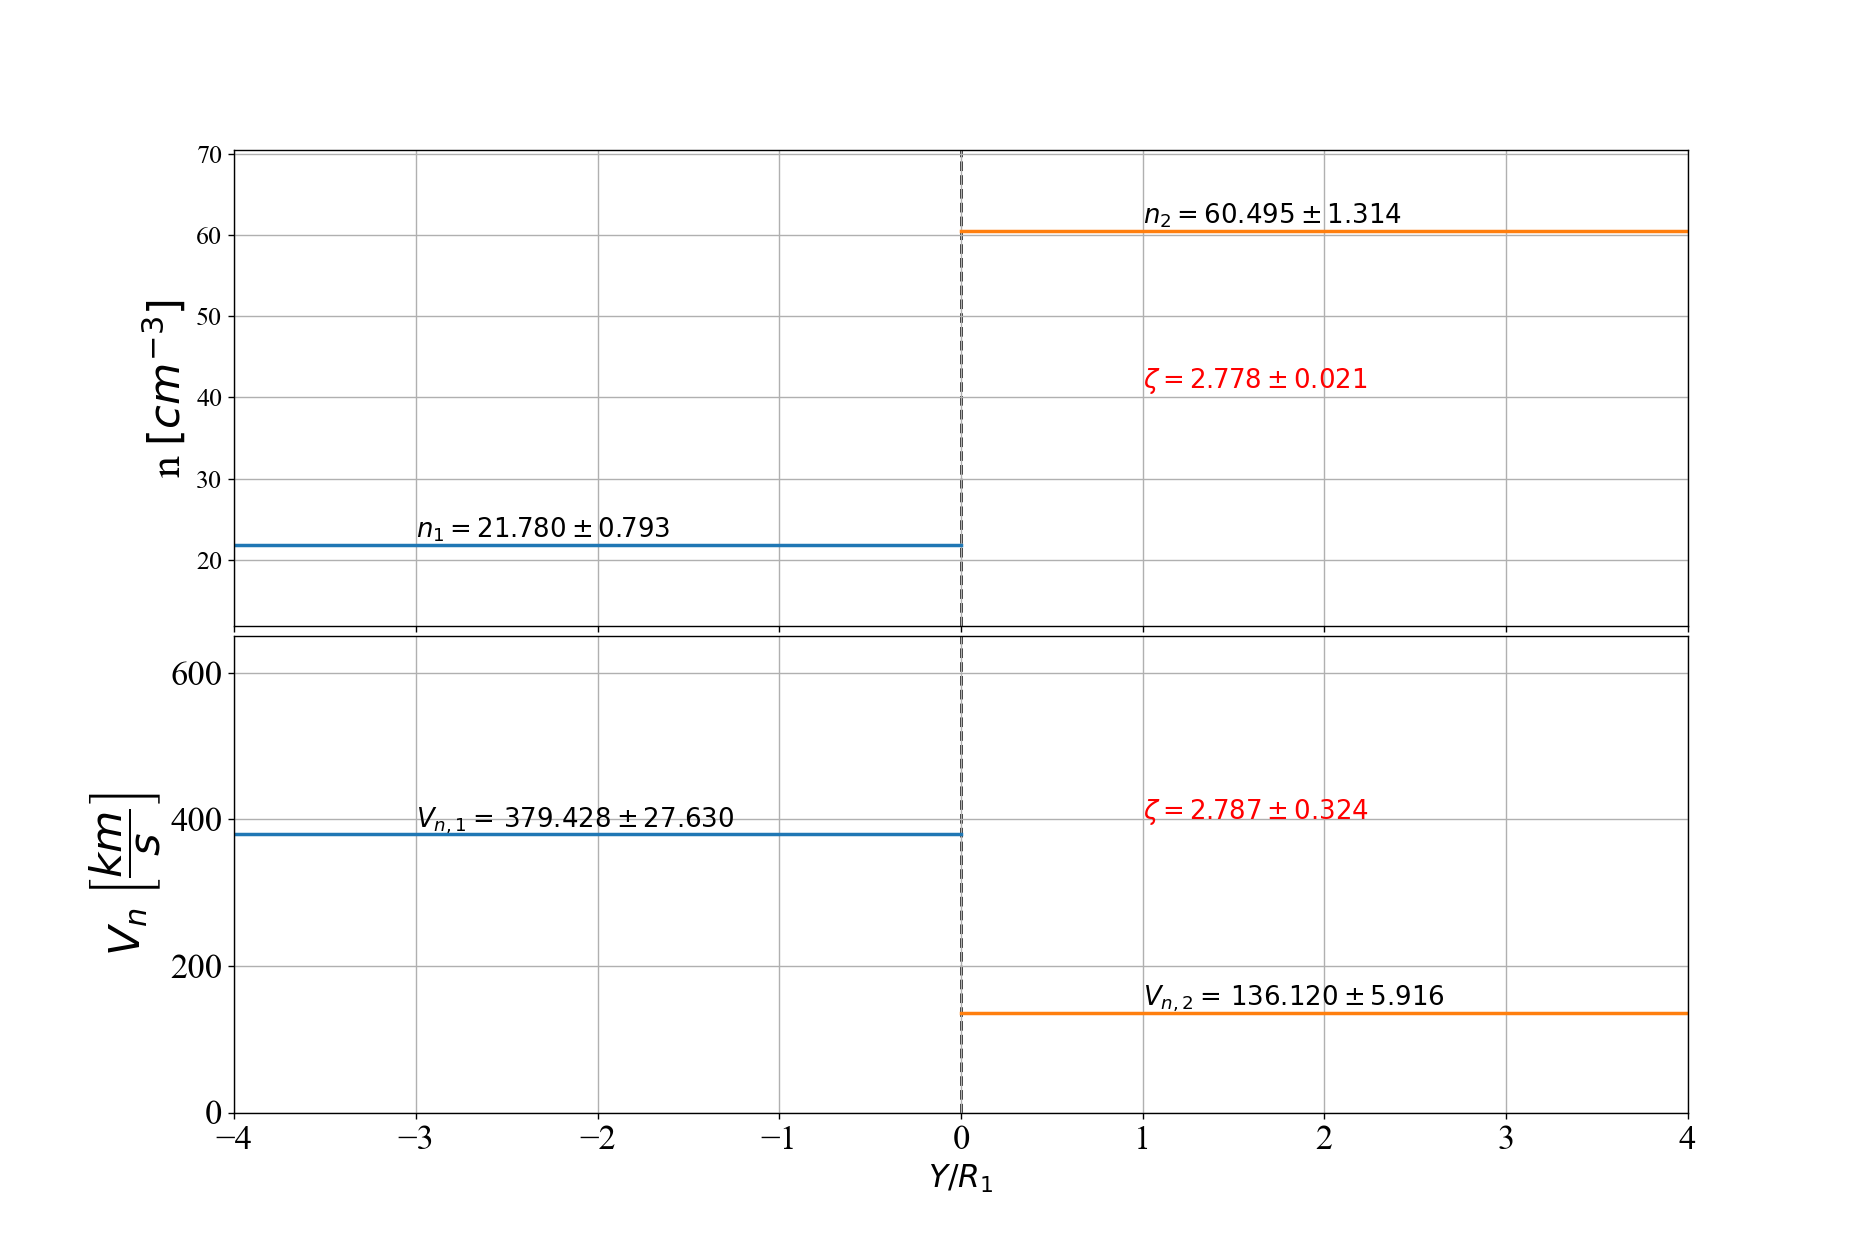

In [56]:
fig,ax = plt.subplots(2,gridspec_kw={'hspace': 0.02},figsize=(15,10))

n_1 = np.linspace(d_up, d_up, 50)
n_2 = np.linspace(d_dw, d_dw, 50)

v_1 = np.linspace(v_up*1e2, v_up*1e2, 50)
v_2 = np.linspace(v_dw*1e2, v_dw*1e2, 50)

xx_1 = np.linspace(-4,0, 50)
xx_2 = np.linspace(0,4, 50)

#Gráfico de densidade

ax[0].annotate(f'$n_1 = {round(d_up,3)}0 \pm {round(err_up,3)}$',    xy= (-3,d_up+1), size=15)  
ax[0].annotate(f'$n_2 = {round(d_dw,3)} \pm {round(err_dw,3)}$',    xy= (1,d_dw + 1), size=15)  
ax[0].annotate(f'$\zeta   = {np.round(d_dw/d_up,3)} \pm {round(deln,3)}$',    xy= (1,(d_dw+d_up)/2), size=15, color='red') 

ax[0].set_ylabel(r'n $\left[cm^{-3} \right]$', size=25)
ax[0].plot(xx_1, n_1, lw=2)
ax[0].plot(xx_2, n_2, lw=2)
ax[0].axvline(0, ls = '--', c = 'k', zorder=1)

ax[0].grid(axis='both'); ymin = round(d_up,3)-10; ymax = round(d_dw,3)+10
ax[0].set_ylim([ymin,ymax])

ax[0].set_xlim([-4,4])
ax[0].set_xticks(np.arange(-4,4.1))

ax[0].tick_params(axis='both',labelsize=15)    
ax[0].label_outer()
#ax[0].set_aspect(1)

#Gráfico da velocidade

ax[1].annotate("$V_{n,1}$" + f'$ =  \, {round(v_up*1e2,3)} \pm {round(Del_vup*1e2,3)}0$',xy= (-3,v_up*1e2+10), size=15)  
ax[1].annotate("$V_{n,2}$" + f'$ =  \, {round(v_dw*1e2,3)}0 \pm {round(Del_vdw*1e2,3)}$',xy= (1,v_dw*1e2+10), size=15)  
ax[1].annotate(f'$\zeta  = {np.round(v_up/v_dw,3)} \pm {round(del_rv,3)}$',    xy= (1,400), size=15, color='red') 


ax[1].set_ylabel(r'$V_n$ '+ r'$ \left[\dfrac{km}{s} \right]$', size=25)
ax[1].set_xlabel(r'$Y/R_1$', size=18)
ax[1].plot(xx_1, v_1, lw=2)
ax[1].plot(xx_2, v_2, lw=2)
ax[1].axvline(0, ls = '--', c = 'k', zorder=1)
ax[1].grid(axis='both')
ax[1].set_ylim([0,650]);
ax[1].set_xlim([-4,4])
ax[1].set_xticks(np.arange(-4,4.1))

ax[1].tick_params(axis='both',labelsize=20)  
#ax[1].set_aspect(1)

#plt.savefig(path_in+'boris2D\\Parametrosfisicos_50000_particles_01.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.savefig('MonteCarloParametrosfisicos_07102015_3D.png', bbox_inches='tight',facecolor='w', edgecolor='w')

#plt.savefig('MonteCarloParametrosfisicos_07102015_3D.png', bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

### Cálculo da densidade média, em x/R1, ao longo de y/R1 

In [65]:
nerror_up = np.array(nsig_up.sum()/100)
nerror_dw = np.array(nsig_dw.sum()/100)

In [66]:
n_error = np.concatenate((nerror_dw,nerror_up)) # Juntos os dois vetores contendo os erros das medidas de densidade
#n_error

In [67]:
n_m = n_mass.describe().loc['mean']
n_M = np.array(n_m)
n_m

-3.95     21.523308
-3.85     22.107957
-3.75     21.593522
-3.65     21.432141
-3.55     21.295556
            ...    
 19.55    61.454922
 19.65    61.238196
 19.75    61.558892
 19.85    61.138619
 19.95    61.542071
Name: mean, Length: 240, dtype: float64

<IPython.core.display.Javascript object>


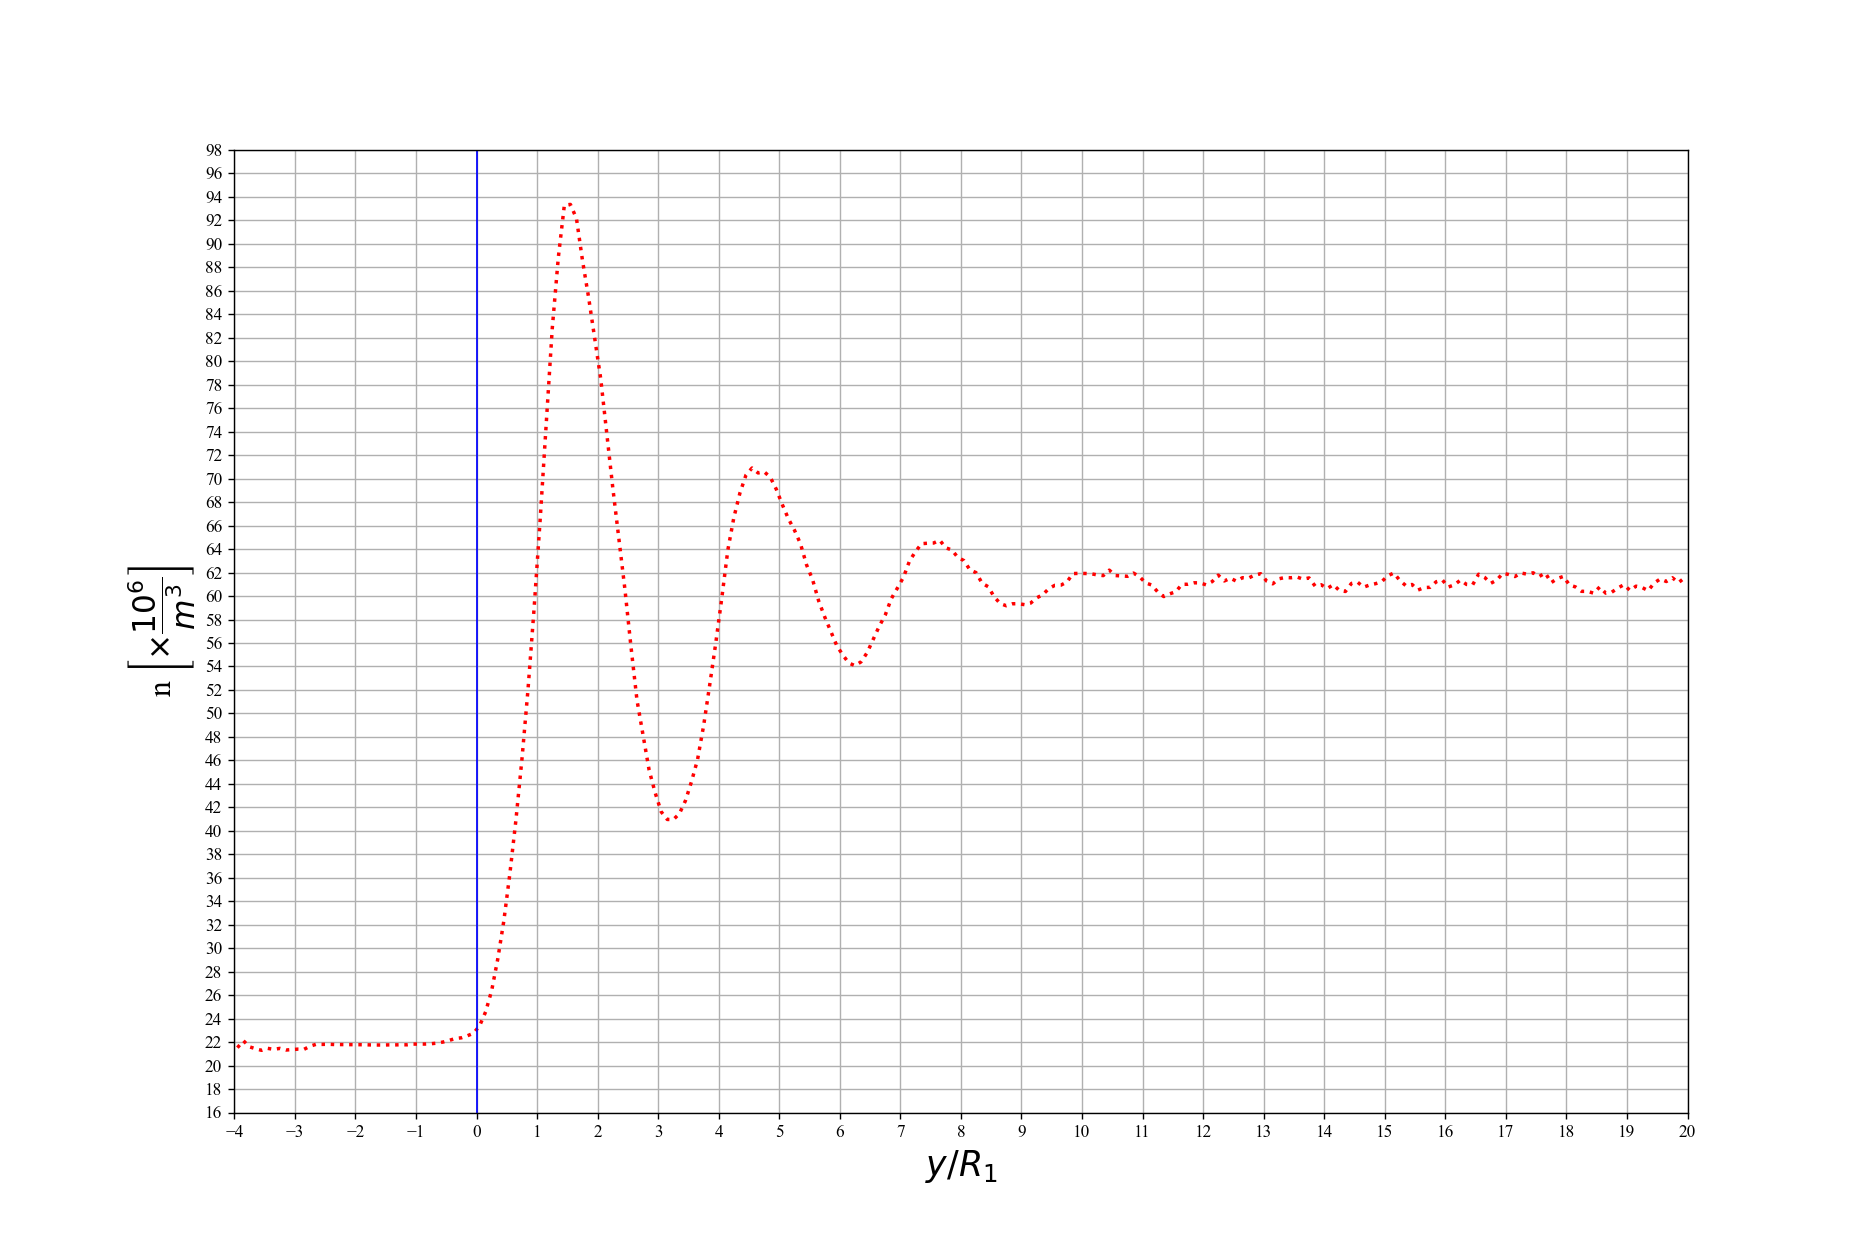

In [70]:
y_d = np.arange(y_1+dy/2,y_2,dy) 

fig,ax = plt.subplots(gridspec_kw={'hspace': 0.02},figsize=(15,10))

ax.plot(y_d, n_M, lw=2, ls=':', color='r')
ax.axvline(0 , color='b',lw=1)
#ax.scatter(y_d[78],n_M[78], lw=10, s=1)

ax.set_xlim([-4,20.])
ax.set_xticks(np.arange(-4,20.5,1))

ax.set_yticks(np.arange(round(min(n_M)-5),max(n_M)+5,2))

ax.set_xlabel(r'$y/R_1$',size= 20)
ax.set_ylabel(r'n $\left[\times \dfrac{10^6}{m^3} \right]$', size=18, color='black')


ax.grid()

## Gráficos adicionais 

<IPython.core.display.Javascript object>


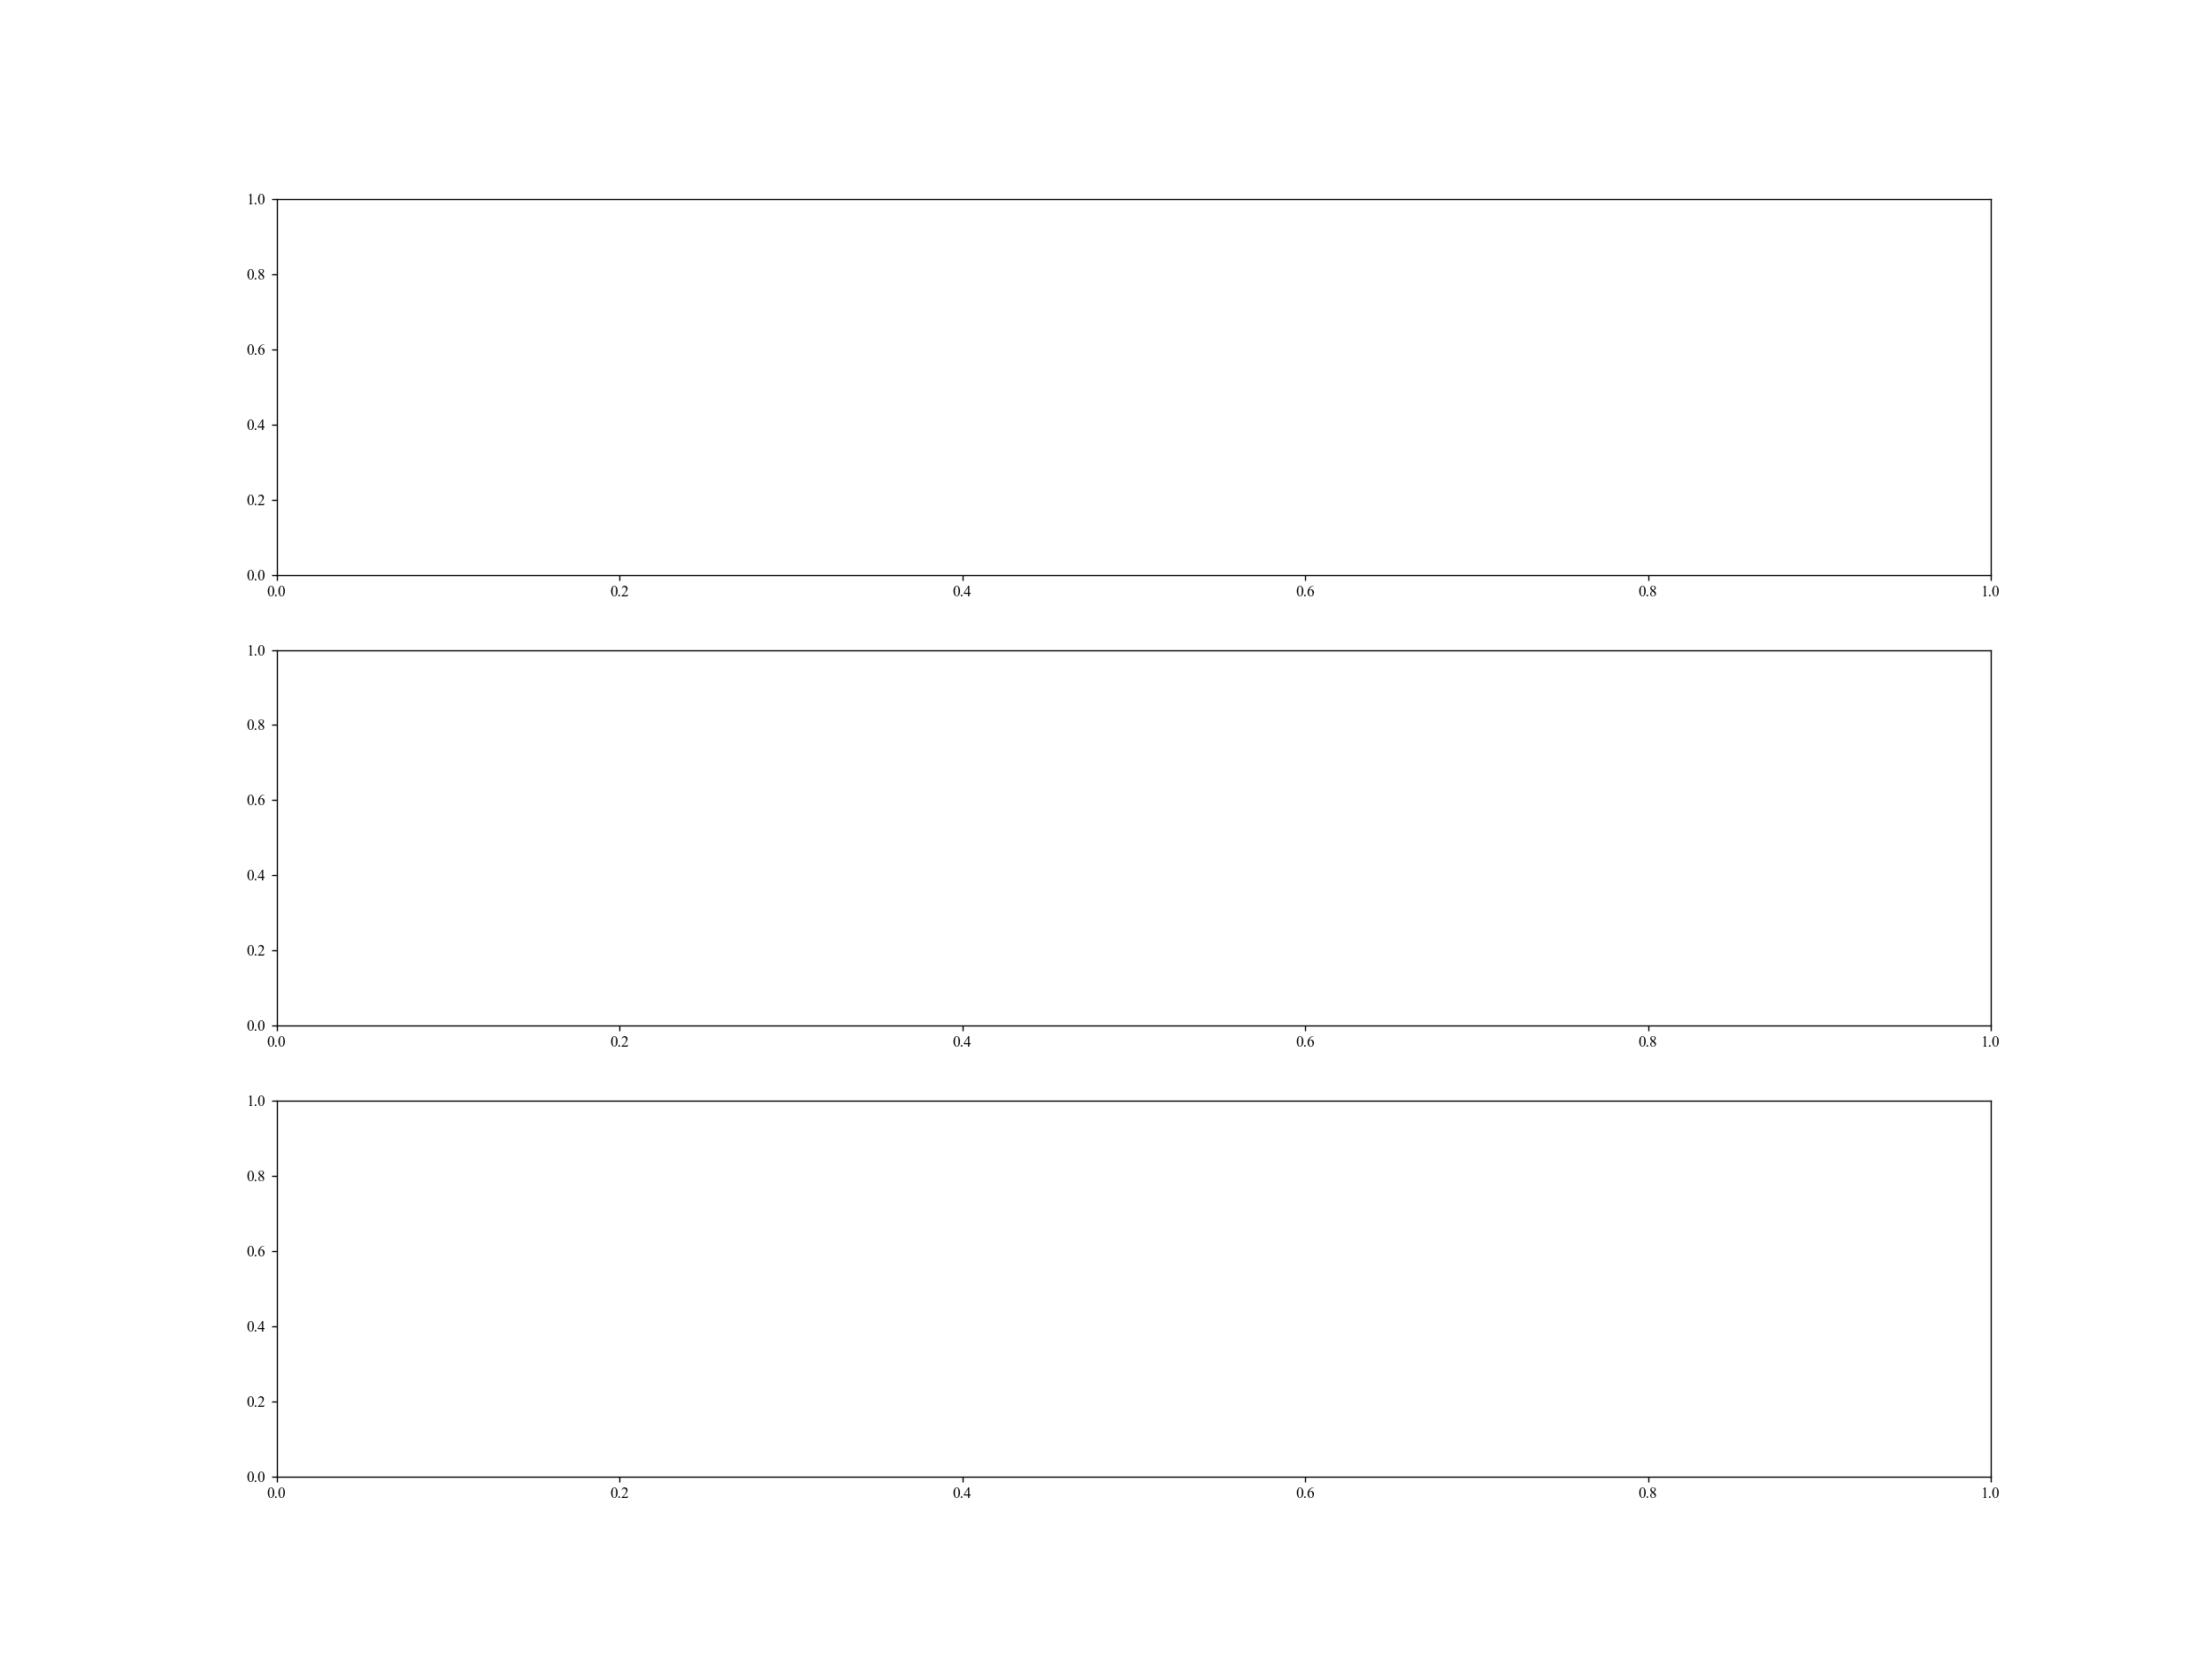

NameError: name 'ry' is not defined

In [69]:
num = 140

fig, ax = plt.subplots(3, figsize=(20, 15))

# Densidade de pontos
ax[0].scatter(ry[:,0:50000:100]/R1,rx[:,0:50000:100]/R1,s=0.0002, color='k')
ax[1].scatter(rx[:,0:50000:100]/R1,rz[:,0:50000:100]/R1,s=0.0002, color='k')
ax[2].scatter(ry[:,0:50000:100]/R1,rz[:,0:50000:100]/R1,s=0.0002, color='k')

for i in range(0,3):
    ax[i].axvline(x = 0,    color='k', linestyle='--',lw=2, zorder=10)
    ax[i].axvline(x = 20.5, color='k', linestyle='--',lw=2, zorder=10)
    ax[i].grid()
        

for j in range(0,5):
    
    ax[0].scatter(ry[:,num*j]/R1,rx[:,num*j]/R1,s=1)
    ax[0].scatter(ry[0,num*j]/R1,rx[0,num*j]/R1,s=50, marker='s', color = 'k')
    
    ax[1].scatter(rx[:,num*j]/R1,rz[:,num*j]/R1,s=1)
    ax[1].scatter(rx[0,num*j]/R1,rz[0,num*j]/R1,s=50, marker='s', color = 'k')
    
    ax[2].scatter(ry[:,num*j]/R1,rz[:,num*j]/R1,s=1)
    ax[2].scatter(ry[0,num*j]/R1,rz[0,num*j]/R1,s=50, marker='s', color = 'k')


ax[0].set_xlim([-4,25]);  
ax[0].set_ylim([-5,5])
ax[0].set_yticks(np.arange(-5,5.1,1))
ax[0].set_xticks(np.arange(-4,25.1,2))
ax[0].set_xlabel(r'$y/R_1$',size=20);ax[0].set_ylabel(r'$x/R_1$',size= 20)

ax[1].set_ylim([-1,1]);  #y0/R1
ax[1].set_xlim([-5,5])
ax[1].set_xticks(np.arange(-5,5.1,1))
ax[1].set_yticks(np.arange(-1,1.1,0.5))
ax[1].set_xlabel(r'$x/R_1$',size=20);ax[1].set_ylabel(r'$z/R_1$',size= 20)

ax[2].set_ylim([-1,1]);  #y0/R1
ax[2].set_xlim([-4,25])
ax[2].set_xticks(np.arange(-4,25.1,2))
ax[2].set_yticks(np.arange(-1,1.1,0.5))
ax[2].set_xlabel(r'$y/R_1$',size=20);ax[2].set_ylabel(r'$z/R_1$',size= 20)


plt.show()

#plt.savefig(path_in+'3D\\'+'Graficodetrajectoria3D_50000_particles.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

In [ ]:
ek = np.loadtxt(path_in+'3D\\'+'ek_skp1.txt'); mu = np.loadtxt(path_in+'3D\\'+'mu_skp1.txt') ; rL = np.loadtxt(path_in+'3D\\'+'rL_skp1.txt')

In [ ]:
fig,ax = plt.subplots(3,gridspec_kw={'hspace': 0.2},figsize=(20,15))
    
for i in range(0,5):
    
    ax[0].scatter(np.arange(1,ek.shape[0]+1), ek[:,num*i], s= 1 ,marker='.')
    ax[1].scatter(np.arange(1,mu.shape[0]+1), mu[:,num*i], s= 1 ,marker='.')
    ax[2].scatter(np.arange(1,rL.shape[0]+1), rL[:,num*i], s= 1 ,marker='.')
    
it1 = np.abs(ry[:,3*num]).argmin()
it2 = np.abs(ry[:,5*num]).argmin()

ax[0].set_ylabel(r'$eK$', size=20)
ax[1].set_ylabel(r'$mu$', size=20)
ax[2].set_ylabel(r'$r_L$', size=20)

for i in range(0,3):
    ax[i].axvline(x = it1, color='k', linestyle='--',lw=2, zorder=10)
    ax[i].axvline(x = it2, color='k', linestyle='--',lw=2, zorder=10)
    
    ax[i].set_xlabel(r'$t$', size=20);
    ax[i].grid(axis='both')
    

plt.show()